<a href="https://colab.research.google.com/github/MathBioCU/WSINDy4Dispersal/blob/main/wsindy_for_dispersal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

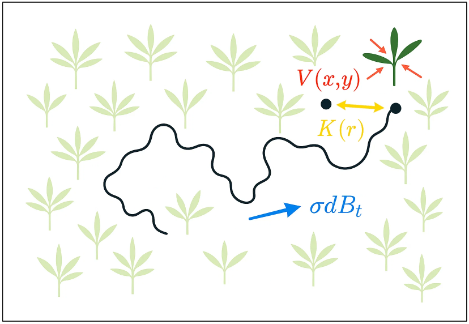

Python code accompanying the manuscript *"Weak Form Learning for Mean-Field Partial Differential Equations: an Application to Caterpillar Movement"*

In [ ]:
%pip install symengine

!wget -q https://raw.githubusercontent.com/SethMinor/PyWSINDy-for-PDEs/main/wsindy.py
!wget -q https://raw.githubusercontent.com/SethMinor/PyWSINDy-for-PDEs/main/helper_fcns.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 16.2 MB/s eta 0:00:00


In [ ]:
# Core
import torch
import scipy
import numpy as np
import matplotlib
import itertools
import symengine as sp
import pandas as pd

# Special
import torch.linalg as la
from scipy.signal import convolve
from scipy.special import factorial
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display,Math

# Weak SINDy
from wsindy import *
from helper_fcns import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/WSINDy

Mounted at /content/drive
/content/drive/My Drive/WSINDy


In [ ]:
# Plot settings
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100
#plt.rcParams['figure.dpi'] = 300

matplotlib.rc('xtick', labelsize=10, direction='out')
matplotlib.rc('ytick', labelsize=10, direction='out')

# Import data

In [ ]:
# Empirical dataset
file_path = '/content/drive/My Drive/WSINDy/Caterpillar/caterpillars.csv'
cats = pd.read_csv(file_path)

# Exclude the trial run (June 15)
cats = cats[cats['Run'] != 'Jun-15']
print(f"Data-frame shape: {cats.shape}")

# Run-specific datasets
cats_march = cats[cats['Run'] == 'Mar-16']
cats_april = cats[cats['Run'] == 'Apr-16']

# Time
t = cats['Time'].unique()
tau = np.linspace(0, 7, 8)
print(f'Times, t = {t}')
print(f'Tau = {tau}')

del file_path

Data-frame shape: (964, 12)
Times, t = [ 0  1  2  4  8 16 24 48]
Tau = [0. 1. 2. 3. 4. 5. 6. 7.]


Experiments:
- $\Omega_1$ (`Plot = 1`): Stonewall, not infected
- $\Omega_2$ (`Plot = 2`): Gasoy, not infected
- $\Omega_3$ (`Plot = 3`): Stonewall, infected
- $\Omega_4$ (`Plot = 4`): Gasoy, infected

In [ ]:
# Which experiments?
run = ['Mar-16', 'Apr-16'] # 'Mar-16' and/or 'Apr-16'
cats = cats[cats['Run'].isin(run)]

# Grouped by common plant type
cats_S = cats[(cats['Run'].isin(run)) & ((cats['Plot'] == 1) | (cats['Plot'] == 3))]
cats_G = cats[(cats['Run'].isin(run)) & ((cats['Plot'] == 2) | (cats['Plot'] == 4))]

# Grouped by common infection statu
cats_N = cats[(cats['Run'].isin(run)) & ((cats['Plot'] == 1) | (cats['Plot'] == 2))]
cats_I = cats[(cats['Run'].isin(run)) & ((cats['Plot'] == 3) | (cats['Plot'] == 4))]

# Separate control populations
cats1 = cats[(cats['Run'].isin(run)) & (cats['Plot'] == 1)]
cats2 = cats[(cats['Run'].isin(run)) & (cats['Plot'] == 2)]
cats3 = cats[(cats['Run'].isin(run)) & (cats['Plot'] == 3)]
cats4 = cats[(cats['Run'].isin(run)) & (cats['Plot'] == 4)]

# Separate control populations by run
cats1_march = cats_march[cats_march['Plot'] == 1]
cats2_march = cats_march[cats_march['Plot'] == 2]
cats3_march = cats_march[cats_march['Plot'] == 3]
cats4_march = cats_march[cats_march['Plot'] == 4]

cats1_april = cats_april[cats_april['Plot'] == 1]
cats2_april = cats_april[cats_april['Plot'] == 2]
cats3_april = cats_april[cats_april['Plot'] == 3]
cats4_april = cats_april[cats_april['Plot'] == 4]

del run

## Histograms

Histogram (empirical measure): $u(\boldsymbol{x},t) = \frac{1}{N_t |\mathcal{B}|}\sum_{k}\sum_{i} \mathbf{1}_{\mathcal{B}_k}(\boldsymbol{x}) \cdot \mathbf{1}_{\mathcal{B}_k}\!\!\left( \mathbf{x}_t^{i} \right)$

In [ ]:
# Bins in (x,y)
#(Nx, Ny) = (40, 40)
#(Nx, Ny) = (50, 50)
(Nx, Ny) = (80, 80)

# Create a 2D histogram for each time
hists = []
hists_SG = [[] for _ in range(2)]
hists_NI = [[] for _ in range(2)]
hists_n = [[] for _ in range(4)]

for tn in t:
  df = cats[cats['Time'] == tn]
  hist,_ = np.histogramdd(
    df[['X', 'Y']].to_numpy(),
    bins = (Nx, Ny),
    range = ((0,175),(0,175)),
    #density = False)
    density = True)
  hists.append(hist)

  # Different plant types
  for n,cats_n in enumerate([cats_S, cats_G]):
    df = cats_n[cats_n['Time'] == tn]
    hist,_ = np.histogramdd(
      df[['X', 'Y']].to_numpy(),
      bins = (Nx, Ny),
      range = ((0, 175), (0, 175)),
      #density = False)
      density = True)
    hists_SG[n].append(hist)

  # Infection status
  for n,cats_n in enumerate([cats_N, cats_I]):
    df = cats_n[cats_n['Time'] == tn]
    hist,_ = np.histogramdd(
      df[['X', 'Y']].to_numpy(),
      bins = (Nx, Ny),
      range = ((0, 175), (0, 175)),
      #density = False)
      density = True)
    hists_NI[n].append(hist)

  # Separate control populations
  for n,cats_n in enumerate([cats1, cats2, cats3, cats4]):
    df = cats_n[cats_n['Time'] == tn]
    hist,_ = np.histogramdd(
      df[['X', 'Y']].to_numpy(),
      bins = (Nx, Ny),
      range = ((0, 175), (0, 175)),
      #density = False)
      density = True)
    hists_n[n].append(hist)

# Convert to torch tensor
U_h = torch.tensor(np.array(hists)).permute(1,2,0)
[UN_h, UI_h] = [torch.tensor(np.array(hists_NI[n])).permute(1,2,0) for n in range(2)]
[US_h, UG_h] = [torch.tensor(np.array(hists_SG[n])).permute(1,2,0) for n in range(2)]
[U1_h, U2_h, U3_h, U4_h] = [torch.tensor(np.array(hists_n[n])).permute(1,2,0) for n in range(4)]
print("Shape of U_h:", U_h.shape)

# Space and time
x = torch.linspace(0, 175, Nx, dtype=torch.float64)
y = torch.linspace(0, 175, Ny, dtype=torch.float64)
X,Y = np.meshgrid(x, y, indexing='ij')
[dx, dy] = [x.diff()[0], y.diff()[0]]
dtau = np.diff(tau)[0]

del tn, df, hist, _, hists, hists_SG, hists_NI, hists_n, n, cats_n

Shape of U_h: torch.Size([80, 80, 8])


1.0254766864284568


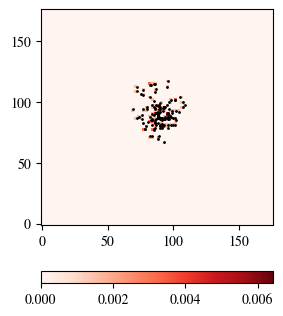

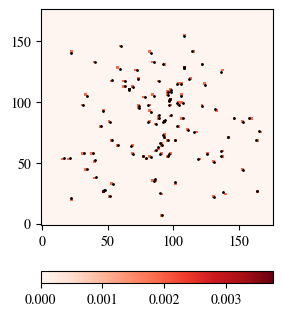

In [ ]:
# Check normalization
print((dx*dy*U_h[:,:,0]).sum().item())

plt.figure(figsize=(3,4))
plt.pcolormesh(X, Y, U_h[:,:,0], cmap='Reds')
plt.colorbar(orientation='horizontal')
plt.scatter(cats[cats['Time'] == 0]['X'], cats[cats['Time'] == 0]['Y'], s=1, color='k')
plt.show()

plt.figure(figsize=(3,4))
plt.pcolormesh(X, Y, U_h[:,:,-1], cmap='Reds')
plt.colorbar(orientation='horizontal')
plt.scatter(cats[cats['Time'] == 48]['X'], cats[cats['Time'] == 48]['Y'], s=1, color='k')
plt.show()

## KDE in $(x,y)$

[Density estimate](https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation): $u(\boldsymbol{x},t) = \frac{1}{2\pi h |\hat{\mathbf{C}}_t|^{0.5}}\sum_{i=1}^{N_t} \exp\left(-\frac{(\boldsymbol{x}-\mathbf{x}_t^i)^T \hat{\mathbf{C}}^{-1}_t (\boldsymbol{x}-\mathbf{x}_t^i)}{2h^2} \right)$

In [ ]:
from scipy.stats import gaussian_kde

def Gaussian_KDE(X, Y, particles):
  G = np.zeros_like(X)
  kernel = gaussian_kde(particles)
  positions = np.vstack([X.ravel(), Y.ravel()])
  G = kernel(positions).reshape(X.shape)
  return G

In [ ]:
# GAUSSIAN KDE
# Bins in (x,y)
#(Nx, Ny) = (50, 50)
(Nx, Ny) = (80, 80)

# KDE evaluation at each time
kdes = []
kdes_SG = [[] for _ in range(2)]
kdes_NI = [[] for _ in range(2)]
kdes_n = [[] for _ in range(4)]
kdes_n_march = [[] for _ in range(4)]
kdes_n_april = [[] for _ in range(4)]

for tn in t:
  df = cats[cats['Time'] == tn]
  particles = np.vstack([df['X'], df['Y']])
  G = Gaussian_KDE(X, Y, particles)
  kdes.append(G)

  # Plant type
  for n,cats_n in enumerate([cats_S, cats_G]):
    df = cats_n[cats_n['Time'] == tn]
    particles = np.vstack([df['X'], df['Y']])
    G = Gaussian_KDE(X, Y, particles)
    kdes_SG[n].append(G)

  # Infection status
  for n,cats_n in enumerate([cats_N, cats_I]):
    df = cats_n[cats_n['Time'] == tn]
    particles = np.vstack([df['X'], df['Y']])
    G = Gaussian_KDE(X, Y, particles)
    kdes_NI[n].append(G)

  # Separate control populations
  for n,cats_n in enumerate([cats1, cats2, cats3, cats4]):
    df = cats_n[cats_n['Time'] == tn]
    particles = np.vstack([df['X'], df['Y']])
    G = Gaussian_KDE(X, Y, particles)
    kdes_n[n].append(G)

  # Separate control populations by run
  for n,cats_n in enumerate([cats1_march, cats2_march, cats3_march, cats4_march]):
    df = cats_n[cats_n['Time'] == tn]
    particles = np.vstack([df['X'], df['Y']])
    G = Gaussian_KDE(X, Y, particles)
    kdes_n_march[n].append(G)

  for n,cats_n in enumerate([cats1_april, cats2_april, cats3_april, cats4_april]):
    df = cats_n[cats_n['Time'] == tn]
    particles = np.vstack([df['X'], df['Y']])
    G = Gaussian_KDE(X, Y, particles)
    kdes_n_april[n].append(G)

# Convert to torch tensor
U = torch.tensor(np.array(kdes)).permute(1,2,0)
[US, UG] = [torch.tensor(np.array(kdes_SG[n])).permute(1,2,0) for n in range(2)]
[UN, UI] = [torch.tensor(np.array(kdes_NI[n])).permute(1,2,0) for n in range(2)]
[U1, U2, U3, U4] = [torch.tensor(np.array(kdes_n[n])).permute(1,2,0) for n in range(4)]
[U1_march, U2_march, U3_march, U4_march] = [torch.tensor(np.array(kdes_n_march[n])).permute(1,2,0) for n in range(4)]
[U1_april, U2_april, U3_april, U4_april] = [torch.tensor(np.array(kdes_n_april[n])).permute(1,2,0) for n in range(4)]
print(f'Shape of U: {U.shape}')

del G, kdes, kdes_SG, kdes_NI, kdes_n, kdes_n_march, kdes_n_april, particles, tn, df, n, cats_n

Shape of U: torch.Size([80, 80, 8])


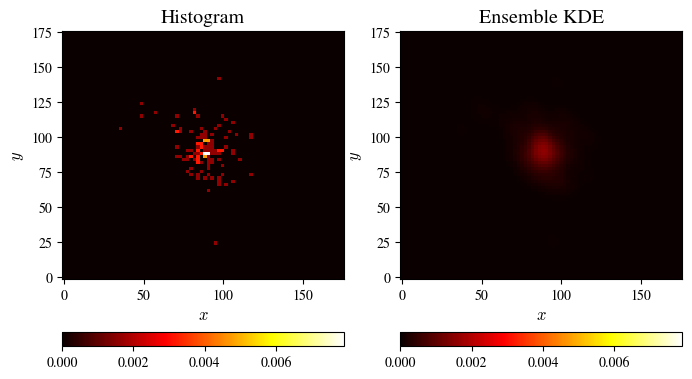

In [ ]:
# Histogram comparison
thyme = 1

fig,ax = plt.subplots(1,2, figsize=(8, 4.6))
pcm0 = ax[0].pcolormesh(X, Y, U_h[:,:,thyme], cmap='hot')
plt.colorbar(pcm0, orientation='horizontal')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[0].set_title('Histogram')

pcm1 = ax[1].pcolormesh(X, Y, U[:,:,thyme], cmap='hot', vmax=U_h[:,:,thyme].max())
plt.colorbar(pcm1, orientation='horizontal')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')
ax[1].set_title('Ensemble KDE')

del fig, ax, pcm0, pcm1, thyme

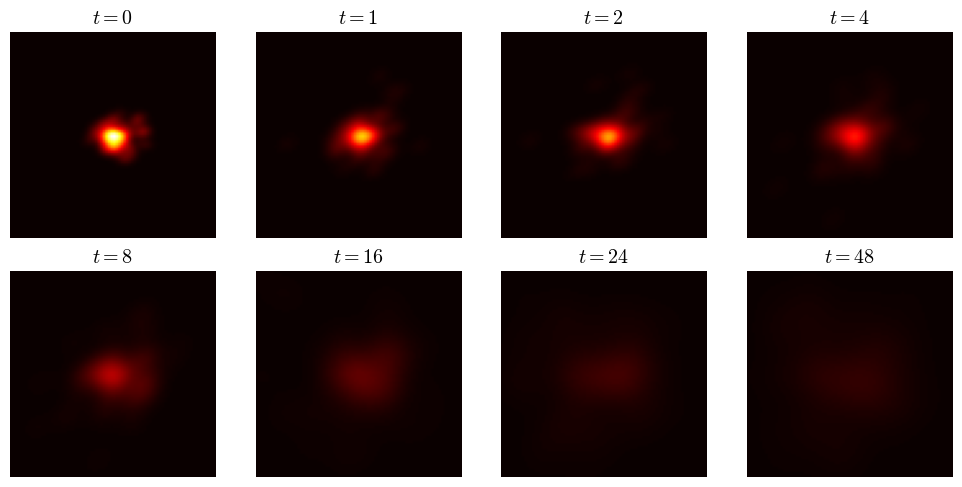

In [ ]:
# SNAPSHOTS
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
vmax = U.max()

for i in range(8):
  ax = axes[i // 4, i % 4]
  im = ax.imshow(U[:, :, i], cmap='hot', vmin=0, vmax=vmax)
  ax.set_title(f'$t={t[i]}$')
  ax.axis('off')
plt.tight_layout()
plt.show()

## Temporal Interpolation

In [ ]:
# Finer time grid
t_new = np.linspace(t[0], t[-1], 49*2)
dt = np.diff(t_new)[0]

In [ ]:
# Spline interpolation
from scipy.interpolate import make_interp_spline

t_spline = make_interp_spline(t, U.numpy(), k=1, axis=2)
U_interp = torch.from_numpy(np.maximum(t_spline(t_new),0))

# Plant type
USG_interp = []
for u in [US, UG]:
  t_spline = make_interp_spline(t, u.numpy(), k=1, axis=2)
  USG_interp.append(torch.from_numpy(np.maximum(t_spline(t_new),0)))
US_interp, UG_interp = USG_interp

# Infection status
UNI_interp = []
for u in [UN, UI]:
  t_spline = make_interp_spline(t, u.numpy(), k=1, axis=2)
  UNI_interp.append(torch.from_numpy(np.maximum(t_spline(t_new),0)))
UN_interp, UI_interp = UNI_interp

# Control populations
Ui_interp = []
for u in [U1, U2, U3, U4]:
  t_spline = make_interp_spline(t, u.numpy(), k=1, axis=2)
  Ui_interp.append(torch.from_numpy(np.maximum(t_spline(t_new),0)))
U1_interp, U2_interp, U3_interp, U4_interp = Ui_interp

# Control populations by run
Ui_march_interp = []
for u in [U1_march, U2_march, U3_march, U4_march]:
  t_spline = make_interp_spline(t, u.numpy(), k=1, axis=2)
  Ui_march_interp.append(torch.from_numpy(np.maximum(t_spline(t_new),0)))
U1_march_interp, U2_march_interp, U3_march_interp, U4_march_interp = Ui_march_interp

Ui_april_interp = []
for u in [U1_april, U2_april, U3_april, U4_april]:
  t_spline = make_interp_spline(t, u.numpy(), k=1, axis=2)
  Ui_april_interp.append(torch.from_numpy(np.maximum(t_spline(t_new),0)))
U1_april_interp, U2_april_interp, U3_april_interp, U4_april_interp = Ui_april_interp

# Check normalization
print((dx*dy*U_interp[:,:,0]).sum().item())

print(U.shape)
print(U_interp.shape)

del USG_interp, UNI_interp, Ui_interp, Ui_march_interp, Ui_april_interp

0.9999999999999989
torch.Size([80, 80, 8])
torch.Size([80, 80, 98])


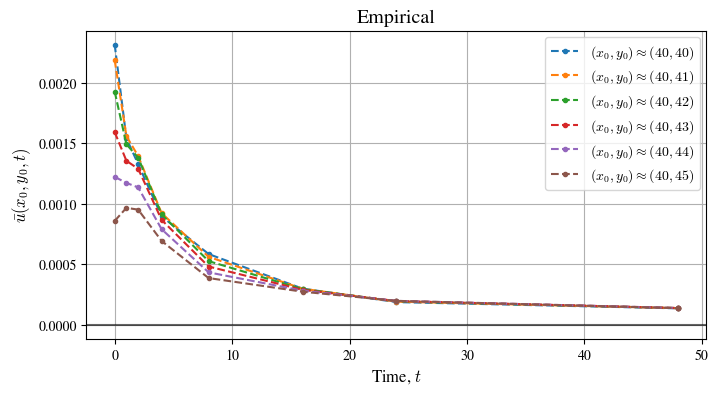

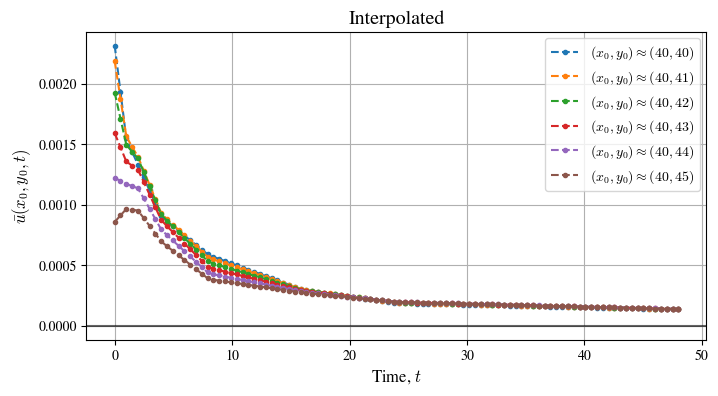

In [ ]:
# LOCAL AVERAGES
def local_average(U, xi, yi, r):
  local = U[max(xi-r,0):min(xi+r+1,U.shape[0]), max(yi-r,0):min(yi+r+1,U.shape[1]), :]
  return local.mean(dim=(0,1))

radius = 0 # No averaging
points = [(40,40), (40,41), (40,42), (40,43), (40,44), (40,45)]
#points = [(40,40), (41,40), (42,40), (43,40), (44,40), (45,40)]

for ind,u in enumerate([U,U_interp]):
  plt.figure(figsize=(8, 4))
  for (xi, yi) in points:
    local = local_average(u, xi, yi, radius)
    plt.plot([t, t_new][ind], local, '.--', label=f'$(x_0,y_0) \\approx ({xi},{yi})$')
  plt.axhline(y=0, color='k', alpha=0.6)
  plt.legend(fontsize=10)
  plt.grid(True)
  plt.title(['Empirical', 'Interpolated'][ind])
  plt.xlabel(r'Time, $t$')
  plt.ylabel(r'$\bar{u}(x_0,y_0,t)$')
  plt.show()

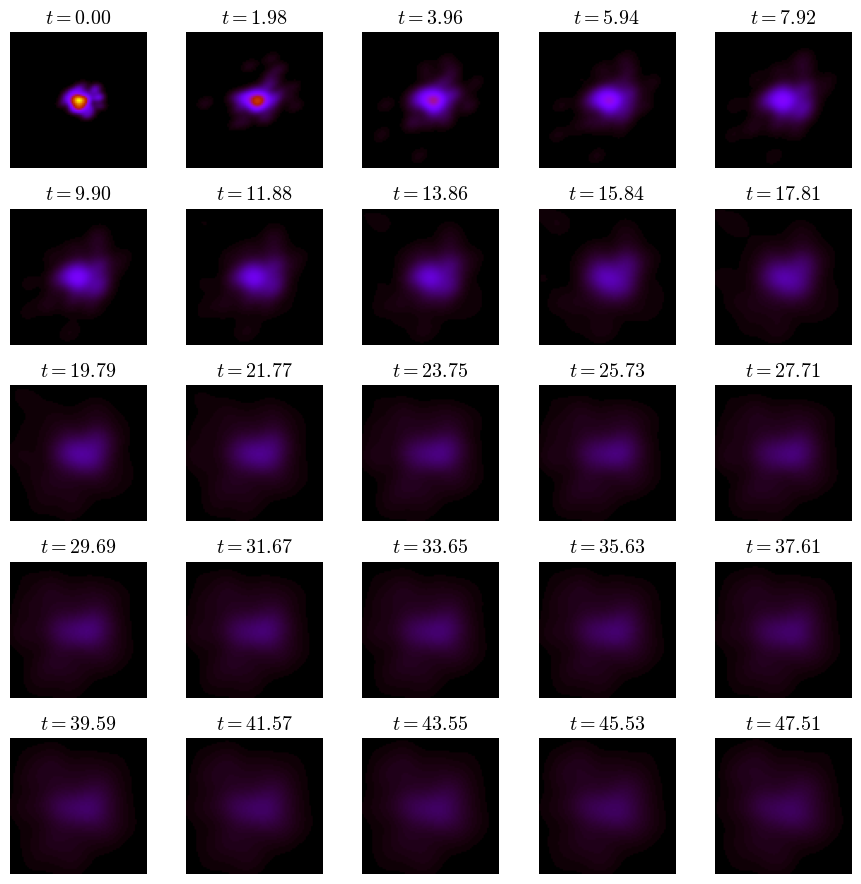

In [ ]:
# INTERPOLATED SNAPSHOTS
fig, axes = plt.subplots(5, 5, figsize=(9, 9))
vmax = U_interp.max()

for i in range(25):
  ax = axes[i // 5, i % 5]
  im = ax.imshow(U_interp[:, :, 4*i], cmap='gnuplot', vmin=0, vmax=vmax)
  ax.set_title(f'$t={t_new[4*i]:.2f}$')
  ax.axis('off')
plt.tight_layout()
plt.show()

# Data analysis

Volumetric plot of the 3D density

In [ ]:
# Make a density plot of the data?
PLOTME = False

if PLOTME == True:
  from mpl_toolkits.mplot3d import Axes3D
  from scipy.stats import gaussian_kde

  plt.rcParams['mathtext.fontset'] = 'cm'
  plt.rcParams['font.family'] = 'STIXGeneral'
  fig = plt.figure(figsize=(16, 10))

  # Loop through each time and create a subplot
  for i, thyme in enumerate(t.tolist()):

    # Extract (x,y,z) coords
    df = cats[cats['Time'] == thyme]
    X = df['X']
    Y = df['Y']
    Z = df['Z']

    # Create a grid for KDE
    (Nx, Ny, Nz) = (80, 80, 61)
    xgrid = np.linspace(0, 175, Nx)
    ygrid = np.linspace(0, 175, Ny)
    zgrid = np.linspace(0, 60, Nz)
    xmesh, ymesh, zmesh = np.meshgrid(xgrid, ygrid, zgrid)
    grid_coords = np.vstack([xmesh.ravel(), ymesh.ravel(), zmesh.ravel()])

    # KDE evaluation
    kde = gaussian_kde(np.vstack([X, Y, Z]), bw_method=0.25)
    density = kde(grid_coords).reshape((Nx, Ny, Nz))
    density_threshold = 1e-7
    x_dense, y_dense, z_dense = xmesh[density > density_threshold], \
                                ymesh[density > density_threshold], \
                                zmesh[density > density_threshold]
    density = density[density > density_threshold]

    # Scatter plot
    ax = fig.add_subplot(2,4, i+1, projection='3d')
    ax.scatter(x_dense, y_dense, z_dense, c=density, cmap='Reds', alpha=0.02,
               s=5, vmin=density_threshold, vmax=5e-5)
    ax.scatter(X, Y, Z, '.', color='black', s=10, linewidth=0.5)

    ax.set_xlim(0, 175)
    ax.set_ylim(0, 175)
    ax.set_zlim(0, 60)
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$y$', fontsize=20)
    ax.set_title(f'$t = {thyme}$ hr', pad=0, fontsize=20)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.tick_params(axis='both', which='major', labelsize=13)

  plt.tight_layout()
  plt.show()

del PLOTME

Table of learned diffusion constants by population

In [ ]:
# LEARNED DIFFUSION CONSTANTS (PDE)
# Effective constants +/- two sigma
Deffs = [[5.3,  0.1], # N,S
         [10.9, 0.2], # N,G
         [8.7,  0.4], # I,S
         [8.2,  0.2]] # I,G

# Dx constants +/- two sigma
DXs = [[4.0,  0.2], # N,S
       [11.9, 0.2], # N,G
       [11.1, 0.5], # I,S
       [9.1,  0.3]] # I,G

# Dy constants +/- two sigma
DYs = [[7.2, 0.2], # N,S
       [9.5, 0.3], # N,G
       [6.0, 0.4], # I,S
       [6.8, 0.4]] # I,G

# Dxy constants +/- two sigma
DXYs = [[2.5,  0.3], # N,S
        [-1.6, 0.4], # N,G
        [-0.9, 0.6], # I,S
        [-0.6, 0.5]] # I,G

In [ ]:
# EXAMPLE DIFFUSION CONSTANTS (EMPIRICAL)
# Empirical effective constants +/- error
Deffs_emp = [[4.0,  0.7], # N,S
             [11.4, 1.4], # N,G
             [5.9,  1.0], # I,S
             [6.1,  1.0]] # I,G

# Empirical Dx constants +/- error
DXs_emp = [[1.4,  0.6], # N,S
           [10.8, 2.1], # N,G
           [3.3,  0.9], # I,S
           [9.2,  1.5]] # I,G

# Empirical Dy constants +/- error
DYs_emp = [[7.9,  1.1], # N,S
           [11.1, 1.9], # N,G
           [7.2,  1.4], # I,S
           [5.8,  1.3]] # I,G

# Empirical Dxy constants +/- error
DXYs_emp = [[-1.0, 1.2], # N,S
            [-2.8, 1.9], # N,G
            [0.5,  1.3], # I,S
            [-4.2, 2.3]] # I,G

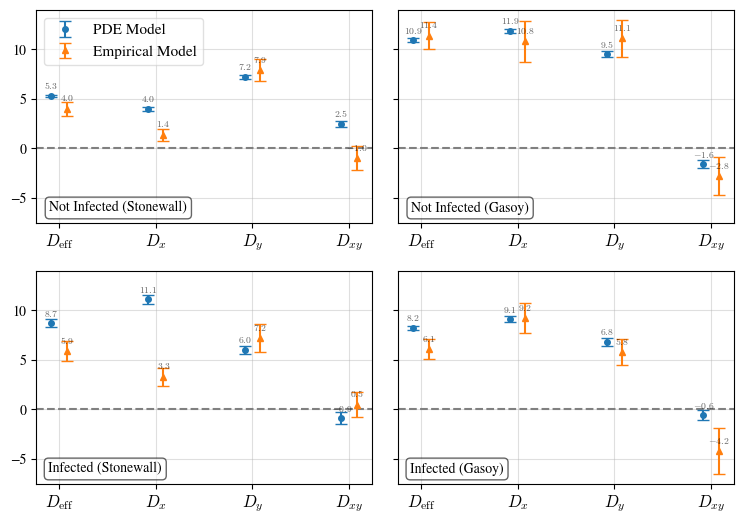

In [ ]:
# COMPARE DIFFUSION CONSTANTS
# Make plot?
PLOTME = True

if PLOTME:
  cases = ['Not Infected (Stonewall)','Not Infected (Gasoy)',
          'Infected (Stonewall)','Infected (Gasoy)']
  names = [r'$D_{\rm{eff}}$', r'$D_x$', r'$D_y$', r'$D_{xy}$']

  # Stack per‐case for easy indexing
  pde_vals = np.array([Deffs, DXs, DYs, DXYs]).transpose((2,0,1))
  emp_vals = np.array([Deffs_emp, DXs_emp, DYs_emp, DXYs_emp]).transpose((2,0,1))
  offsets = [0, -0.06, -0.075, -0.135]

  # Plotting
  fig,axes = plt.subplots(2,2, figsize=(8,6), sharey=True)
  names_ax = np.arange(len(names))

  for i,ax in enumerate(axes.flat):
    # Extract value and error for each case
    pde_mean = pde_vals[0,:,i]
    pde_err  = pde_vals[1,:,i]
    emp_mean = emp_vals[0,:,i]
    emp_err  = emp_vals[1,:,i]

    # Error bars
    ax.axhline(y=0, ls='--', color='gray')
    ax.errorbar(names_ax-0.08, pde_mean, yerr=pde_err, fmt='o', ms=4,
                capsize=4, label='PDE Model', alpha=1)
    ax.errorbar(names_ax+0.08, emp_mean, yerr=emp_err, fmt='^', ms=4,
                capsize=4, label='Empirical Model', alpha=1)

    for j in names_ax:
      #pde_loc = pde_mean[j] + pde_err[j] + 0.06
      pde_loc = pde_mean[j] + 0.48
      #pde_str = f"${pde_mean[j]:.1f}\\pm{pde_err[j]:.1f}$"
      pde_str = f"${pde_mean[j]:.1f}$"
      ax.text(j-0.08, pde_loc, pde_str, fontsize=7, ha='center', va='bottom', alpha=0.6)

      #emp_loc = emp_mean[j] + emp_err[j] + 0.06
      emp_loc = emp_mean[j] + 0.54
      #emp_str = f"${emp_mean[j]:.1f}\\pm{emp_err[j]:.1f}$"
      emp_str = f"${emp_mean[j]:.1f}$"
      ax.text(j+0.08, emp_loc, emp_str, fontsize=7, ha='center', va='bottom', alpha=0.6)

    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.6)
    ax.text(0.45+offsets[i], 0.1, cases[i], transform=ax.transAxes, fontsize=10,
        va='top', ha='right', bbox=bbox)

    ax.set_xticks(names_ax)
    ax.set_xticklabels(names, fontsize=12)
    ax.grid(True, alpha=0.4)
    if i == 0:
      ax.legend(loc='upper left', fontsize=11, framealpha=0.6)

  fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])
  plt.show()

Diffusion curves with violin plots

In [ ]:
# Fcn to fit empirical diffusion constants
from scipy.optimize import curve_fit

def diffusion_fit(t, y, CIs, C0, model='sqrt'):
  # Extract errors
  [CIs_low, CIs_high] = CIs
  error_y = (np.array(CIs_high) + np.array(CIs_low))/4
  params = {'sigma':error_y, 'absolute_sigma':True}

  # Fit diffusion curve
  if model == 'sqrt':
    model = lambda tn,D: np.sqrt(C0*D*tn)
  elif model == '2Dt':
    model = lambda tn,D: 2*D*tn

  D_fit, var_D = curve_fit(model, t, y, **params)
  return D_fit[0], np.sqrt(var_D[0,0])

In [ ]:
# DIFFUSION CURVES AND FITS
from scipy import stats

# Choose from: ['horizontal', 'X', 'Y', 'XY' 'Z']
direction = 'horizontal'

# Choose from: [Deffs, DXs, DYs, DXYs]
D_list = Deffs

# Make plot?
PLOTME = False

if PLOTME:
  datasets = [cats1, cats2, cats3, cats4]
  titles   = ['Not Infected (Stonewall)', 'Not Infected (Gasoy)',
              'Infected (Stonewall)', 'Infected (Gasoy)']
  colors = ['Blue', 'Blue', 'Green', 'Green']
  styles = ['-', '--', '-', '--']

  fig, axes = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=True)
  zipper = zip(axes.flat, datasets, titles, colors, styles, D_list)

  for ax, df, title, color, style, D_pm in zipper:
    df = df.sort_values('Time')
    means = []
    CIs_low = []
    CIs_high = []

    # Compute means and bootstrapped CIs
    for ti in t:
      if direction == 'horizontal':
        data = df[df['Time']==ti][direction].dropna().values
      elif (direction == 'X') or (direction == 'Y'):
        data = np.abs(df[df['Time'] == ti][direction].dropna() - 175/2)
      elif direction == 'XY':
        data_x = df[df['Time']==ti]['X'].dropna() - 175/2
        data_y = df[df['Time']==ti]['Y'].dropna() - 175/2
        data = data_x * data_y
      elif direction == 'Z':
        data = df[(df['Time'] == ti) & (df['Z'] <= 70)]['Z'].dropna()
      m = data.mean()
      means.append(m)

      # Bootstrap
      boots = 1000
      samp = np.random.choice(data, (len(data), boots))
      boot_means = samp.mean(axis=0)
      low, high = np.percentile(boot_means, [2.5, 97.5])
      CIs_low.append(m - low)
      CIs_high.append(high - m)

    # Multiplication factor
    if direction == 'horizontal':
      C0 = np.pi
    else:
      C0 = 4/np.pi

    # Fit empirical diffusion coefficients
    errs = np.vstack([CIs_low, CIs_high])
    if direction == 'XY':
      D_fit,sigma_D = diffusion_fit(t, means-means[0], errs.tolist(), C0, model='2Dt')
      print(f'Direction = {direction}, Case = {title}')
      print(f'Fitted Dij = {D_fit:.3f} ± {sigma_D:.3e}\n')
    elif direction != 'Z':
      D_fit,sigma_D = diffusion_fit(t, means-means[0], errs.tolist(), C0)
      print(f'Direction = {direction}, Case = {title}')
      print(f'Fitted Dij = {D_fit:.3f} ± {sigma_D:.3e}\n')

    # Diffusion curves (main panel)
    ax.axhline(y=0, ls='--', color='gray', alpha=0.8, label='Mean ($t=0$)')
    ax.errorbar(t, means-means[0], yerr=errs, fmt='o'+style, color=color, capsize=2,
                linewidth=1, markersize=5, ecolor='gray', label='Data $\pm\,2\sigma$')

    # Plot continuous fitted models
    if (direction=='horizontal') or (direction=='X') or ((direction=='Y')):

      # Fitted empirical model
      y_c = np.sqrt(C0*D_fit*t_new)
      y_high = np.sqrt(C0*(D_fit+sigma_D)*t_new)
      y_low = np.sqrt(C0*(D_fit-sigma_D)*t_new)
      ax.plot(t_new, y_c, color='gray', lw=1)
      ax.fill_between(t_new, y_low, y_high, color=color, alpha=0.3, label='Empirical Model')

      # Weak-form PDE model
      [Di, two_sigma] = D_pm
      y_c = np.sqrt(C0*Di*t_new)
      y_high = np.sqrt(C0*(Di+two_sigma)*t_new)
      y_low = np.sqrt(C0*(Di-two_sigma)*t_new)
      ax.plot(t_new, y_c, color='gray', lw=1)
      ax.fill_between(t_new, y_low, y_high, color='orange', alpha=0.6, label='PDE Model')

    elif direction == 'XY':

      # Fitted empirical model
      y_c = 2*D_fit*t_new
      y_high = 2*(D_fit+sigma_D)*t_new
      y_low = 2*(D_fit-sigma_D)*t_new
      ax.plot(t_new, y_c, color='gray', lw=1)
      ax.fill_between(t_new, y_low, y_high, color=color, alpha=0.3, label='Empirical Model')

      # Weak-form PDE model
      [Di, two_sigma] = D_pm
      y_c = 2*Di*t_new
      y_high = 2*(Di+two_sigma)*t_new
      y_low = 2*(Di-two_sigma)*t_new
      ax.plot(t_new, y_c, color='gray', lw=1)
      ax.fill_between(t_new, y_low, y_high, color='orange', alpha=0.6, label='PDE Model')

    ax.grid(True, which='both', linestyle='-', lw=0.5, alpha=0.4)
    ax.set_xlim(-1, max(t)+3)
    ax.legend(loc='upper right', framealpha=0.4, fontsize=10)

    # Print case
    bbox=dict(facecolor='white', edgecolor='k', boxstyle='round,pad=0.3', alpha=0.7)
    ax.text(0.98, 0.09, title, transform=ax.transAxes, fontsize=10,
            va='top', ha='right', bbox=bbox)

    # Violin plots (inset panel)
    inset_ax = ax.inset_axes([0.014, 0.68, 0.55, 0.3]) # [x0, y0, W, H]
    inset_ax.axhline(y=means[0], ls='--', lw=0.7, color='gray', alpha=0.8)

    for i, ti in enumerate(t):
      if direction == 'horizontal':
        data = df[df['Time']==ti][direction].dropna().values
      elif (direction == 'X') or (direction == 'Y'):
        data = np.abs(df[df['Time'] == ti][direction].dropna() - 175/2)
      elif direction == 'XY':
        data_x = df[df['Time']==ti]['X'].dropna() - 175/2
        data_y = df[df['Time']==ti]['Y'].dropna() - 175/2
        data = data_x * data_y
      elif direction == 'Z':
        data = df[(df['Time'] == ti) & (df['Z'] <= 70)]['Z'].dropna()

      # Clip outliers?
      lower, upper = np.percentile(data, [0, 99.5])
      clean = data[(data>=lower) & (data<=upper)]
      parts = inset_ax.violinplot(clean, [tau[i]], widths=1, showmeans=True,
                                  showextrema=True, side='high', points=20)
      for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('gray')
        pc.set_alpha(0.6)
      for key in ['cmins','cmeans','cmaxes','cbars']:
        parts[key].set_color('gray')
        parts[key].set_alpha(0.6)

    inset_ax.grid(True, alpha=0.3)
    inset_ax.set_xlim(min(tau)-0.2, max(tau)+0.7)
    inset_ax.set_xticks([])
    inset_ax.yaxis.tick_right()
    if direction == 'XY':
      inset_ax.yaxis.set_tick_params(labelsize=6)
      inset_ax.set_yscale('symlog')
    else:
      inset_ax.yaxis.set_tick_params(labelsize=9)
    inset_ax.set_xlabel('Snapshot, $n$', fontsize=9, loc='left')

    if direction == 'horizontal':
      ax.set_ylim(-2.5, 75)
      inset_ax.set_ylim(-1, 90)
    elif direction == 'X':
      ax.set_ylim(-2.5, 50)
      inset_ax.set_ylim(-1, 75)
    elif direction == 'Y':
      ax.set_ylim(-2.5, 50)
      inset_ax.set_ylim(-1, 75)
    elif direction == 'XY':
      ax.set_ylim(-1.2e3, 1.5e3)
      inset_ax.set_ylim(-4.5e3, 4.5e3)
    elif direction == 'Z':
      ax.set_ylim(-8, 30)
      inset_ax.set_ylim(-2, 60)

  # Global labels
  if direction == 'horizontal':
    s1 = r'$\langle|\mathbf{x}_t-\boldsymbol{\mu}|\rangle$'
    s2 = r'$-\langle|\mathbf{x}_0-\boldsymbol{\mu}|\rangle$'
    fig.text(0.035, 0.5, 'Average Displacement, '+s1+s2+' (cm)',
            va='center', rotation='vertical')
  elif direction == 'X':
    s1 = r'$\langle|x_t-\mu_x|\rangle$'
    s2 = r'$-\langle|x_0-\mu_x|\rangle$'
    fig.text(0.035, 0.5, 'Average Displacement, '+s1+s2+' (cm)',
            va='center', rotation='vertical')
  elif direction == 'Y':
    s1 = r'$\langle|y_t-\mu_y|\rangle$'
    s2 = r'$-\langle|y_0-\mu_y|\rangle$'
    fig.text(0.035, 0.5, 'Average Displacement, '+s1+s2+' (cm)',
            va='center', rotation='vertical')
  elif direction == 'XY':
    s1 = r'$\langle(x_t-\mu_x)(y_t-\mu_y)\rangle$'
    s2 = r'$-\langle(x_0-\mu_x)(y_0-\mu_y)\rangle$'
    fig.text(0.035, 0.53, 'Average Displacement, '+s1+s2+r' $(\text{cm}^2)$',
            va='center', rotation='vertical')
  elif direction == 'Z':
    s1 = r'$\langle|z_t-\mu_z|\rangle$'
    s2 = r'$-\langle|z_0-\mu_z|\rangle$'
    fig.text(0.035, 0.5, 'Average Displacement, '+s1+s2+' (cm)',
            va='center', rotation='vertical')

  fig.text(0.53, 0.04, 'Time, $t_n$ (hours)', ha='center')
  plt.tight_layout(rect=[0.05, 0.05, 1, 1])
  plt.show()

del PLOTME

Comparing $x$ versus $y$ diffusion rates (empirical)

In [ ]:
# Make plot?
PLOTME = False

if PLOTME:
  datasets = [cats1, cats2, cats3, cats4]
  titles = ['Not Infected (Stonewall)', 'Not Infected (Gasoy)',
            'Infected (Stonewall)', 'Infected (Gasoy)']
  #styles = ['-', '--', '-', '--']

  fig, axes = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=True)

  for ax, df, title in zip(axes.flat, datasets, titles):
    df = df.sort_values('Time')

    means_x = []
    CIs_low_x = []
    CIs_high_x = []

    means_y = []
    CIs_low_y = []
    CIs_high_y = []

    for i, ti in enumerate(t):
      data_x = np.abs(df[df['Time'] == ti]['X'].dropna() - 175/2)
      data_y = np.abs(df[df['Time'] == ti]['Y'].dropna() - 175/2)

      m_x = data_x.mean()
      m_y = data_y.mean()
      means_x.append(m_x)
      means_y.append(m_y)

      # Boostrap confidence intervals
      boots = 1000

      samp_x = np.random.choice(data_x, (len(data_x), boots))
      boot_means_x = samp_x.mean(axis=0)
      low_x, high_x = np.percentile(boot_means_x, [2.5, 97.5])
      CIs_low_x.append(m_x - low_x)
      CIs_high_x.append(high_x - m_x)

      samp_y = np.random.choice(data_y, (len(data_y), boots))
      boot_means_y = samp_y.mean(axis=0)
      low_y, high_y = np.percentile(boot_means_y, [2.5, 97.5])
      CIs_low_y.append(m_y - low_y)
      CIs_high_y.append(high_y - m_y)

    # Fit empirical diffusion coefficients
    C0 = 4/np.pi
    errs_x = np.vstack([CIs_low_x, CIs_high_x])
    errs_y = np.vstack([CIs_low_y, CIs_high_y])
    Dx_fit,sigma_Dx = diffusion_fit(t, means_x-means_x[0], errs_x.tolist(), C0)
    Dy_fit,sigma_Dy = diffusion_fit(t, means_y-means_y[0], errs_y.tolist(), C0)

    # Plot diffusion curves
    y_c = np.sqrt(C0*Dx_fit*t_new)
    y_high = np.sqrt(C0*(Dx_fit + sigma_Dx)*t_new)
    y_low = np.sqrt(C0*(Dx_fit - sigma_Dx)*t_new)
    ax.plot(t_new, y_c, color='blue', lw=1, alpha=0.6)
    ax.fill_between(t_new, y_low, y_high, color='blue', alpha=0.3, label='Empirical Model ($x$)')

    y_c = np.sqrt(C0*Dy_fit*t_new)
    y_high = np.sqrt(C0*(Dy_fit + sigma_Dy)*t_new)
    y_low = np.sqrt(C0*(Dy_fit - sigma_Dy)*t_new)
    ax.plot(t_new, y_c, color='green', lw=1, alpha=0.6)
    ax.fill_between(t_new, y_low, y_high, color='green', alpha=0.3, label='Empirical Model ($y$)')

    # Plot fitted empirical models
    ax.axhline(y=0, ls='--', color='gray', alpha=0.8)
    ax.errorbar(t-0.25, means_x-means_x[0], yerr=errs_x, fmt='o', color='blue', capsize=1.5,
                lw=1, ms=4, ecolor='gray', label='Data $\pm\, 2\sigma$ $(x)$')
    ax.errorbar(t+0.25, means_y-means_y[0], yerr=errs_y, fmt='^', color='green', capsize=1.5,
                lw=1, ms=4, ecolor='gray', label='Data $\pm\, 2\sigma$ $(y)$')

    # Print case
    bbox=dict(facecolor='white', edgecolor='k', boxstyle='round,pad=0.3', alpha=0.7)
    ax.text(0.98, 0.09, title, transform=ax.transAxes, fontsize=10, va='top', ha='right', bbox=bbox)
    ax.grid(True, which='both', linestyle='-', lw=0.5, alpha=0.4)

    if title == 'Not Infected (Stonewall)':
      ax.legend(loc='upper left', framealpha=0.6, fontsize=9)

  fig.text(0.04, 0.5, r'Average Displacement, $x$ vs. $y$ (cm)', va='center', rotation='vertical')
  fig.text(0.5, 0.04, r'Time, $t_n$ (hours)', va='center')
  plt.tight_layout(rect=[0.05, 0.05, 1, 1])
  plt.show()

# Learned dynamics

In [ ]:
# PICK DATASET
U_ws = U_interp.clone() # Ensemble

# Grouped by plant type or infection status
#U_ws = US_interp.clone() # Plant type = S
#U_ws = UG_interp.clone() # Plant type = G
#U_ws = UN_interp.clone() # Infection = N
#U_ws = UI_interp.clone() # Infection = I

# Separate control populations
#U_ws = U1_interp.clone() # S,N
#U_ws = U2_interp.clone() # G,N
#U_ws = U3_interp.clone() # S,I
#U_ws = U4_interp.clone() # G,I

# Separate control populations by run
#U_ws = U1_march_interp.clone() # S,N (march)
#U_ws = U2_march_interp.clone() # G,N (march)
#U_ws = U3_march_interp.clone() # S,I (march)
#U_ws = U4_march_interp.clone() # G,I (march)

#U_ws = U1_april_interp.clone() # S,N (april)
#U_ws = U2_april_interp.clone() # G,N (april)
#U_ws = U3_april_interp.clone() # S,I (april)
#U_ws = U4_april_interp.clone() # G,I (april)

# Grid
try:
  t = torch.from_numpy(t)
  t_new = torch.from_numpy(t_new)
except:
  pass

X2,Y2 = torch.meshgrid(x,y, indexing='ij')
X,Y,T = torch.meshgrid(x,y,t_new, indexing='ij')

In [ ]:
N_data = cats.shape[0]

#N_data = cats_S.shape[0]
#N_data = cats_G.shape[0]
#N_data = cats_N.shape[0]
#N_data = cats_I.shape[0]

#N_data = cats1.shape[0]
#N_data = cats2.shape[0]
#N_data = cats3.shape[0]
#N_data = cats4.shape[0]

#N_data = cats1_march.shape[0]
#N_data = cats2_march.shape[0]
#N_data = cats3_march.shape[0]
#N_data = cats4_march.shape[0]

#N_data = cats1_april.shape[0]
#N_data = cats2_april.shape[0]
#N_data = cats3_april.shape[0]
#N_data = cats4_april.shape[0]

print(f'Number of cat. counts = {N_data}')

Number of cat. counts = 964


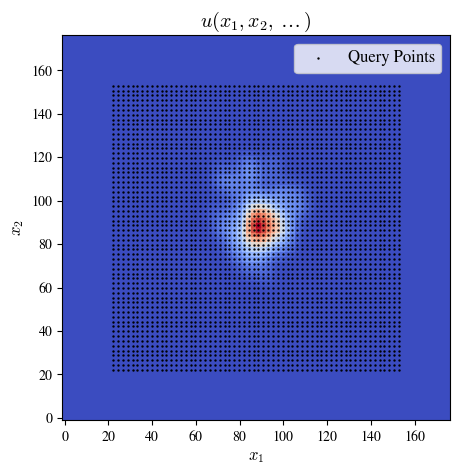

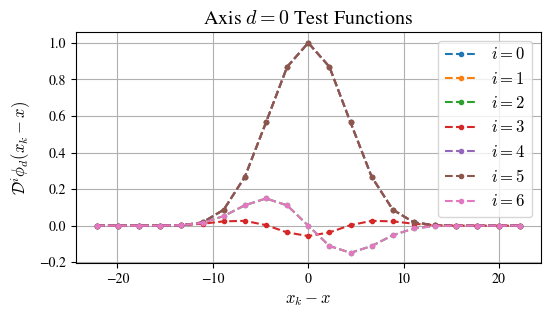

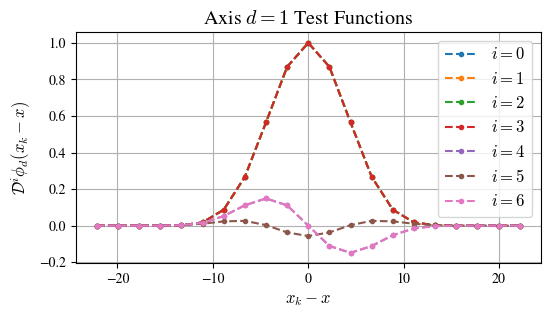

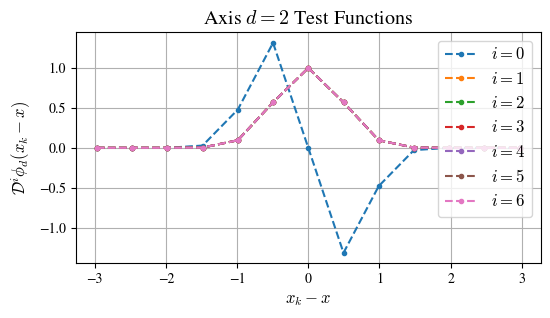

In [ ]:
coords = [x, y, t_new]
vars = []
names = ['u']

m = [10, 10, 6]
s = [1, 1, 1]

# Derivatives for test fcns
alpha = [[0,0,1], # d/dt (lhs)
         [0,0,0], # 1
         [1,0,0], # d/dx
         [2,0,0], # d^2/dx^2
         [0,1,0], # d/dy
         [0,2,0], # d^2/dy^2
         [1,1,0]] # d^2/dxdy

# Powers for homogeneous fcns
beta = [[0],[1]]

# Hyper-params
params = {'V':vars, 'names':names, 'm':m, 's':s, 'rescale':False}

model = WSINDy(U_ws, alpha, beta, coords, **params)

In [ ]:
# Set lhs
lhs_name = 'u' + model.derivative_names[0]
model.build_lhs(lhs_name)

# Create standard library terms
[G, powers, derivs, rhs_names] = model.create_default_library()
[G, powers, derivs, rhs_names] = [G[1:], powers[1:], derivs[1:], rhs_names[1:]]
G_mat = torch.stack(G).T

# Print out symbolic library
lib_string = r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'
display(Math(lib_string))

print(f'Library shape: G = {G_mat.numpy().shape}')
print(f'Condition number: K(G) = {la.cond(G_mat):.2e}\n')

100%|██████████| 6/6 [00:00<00:00, 14.50it/s]


<IPython.core.display.Math object>

Library shape: G = (309600, 6)
Condition number: K(G) = 5.10e+02



Customize library

In [ ]:
# Trim out (u, u_x, u_y) terms?
remove_cols = [0,1,3]
print(f'Removing: {rhs_names[0], rhs_names[1], rhs_names[3]}\n')

# Trim out (u, u_x, u_y, u_xy) terms?
# remove_cols = [0,1,3,5]
# print(f'Removing: {rhs_names[0], rhs_names[1], rhs_names[3], rhs_names[5]}\n')

for column in sorted(remove_cols, reverse=True):
  G.pop(column)
  powers.pop(column)
  derivs.pop(column)
  rhs_names.pop(column)
G_mat = torch.stack(G).T

display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'))
print(f'Library shape: G = {G_mat.numpy().shape}')
print(f'Condition number: K(G) = {la.cond(G_mat):.2e}\n')

del remove_cols,column

Removing: ('(u)', '(u)_{x}', '(u)_{y}')



<IPython.core.display.Math object>

Library shape: G = (309600, 3)
Condition number: K(G) = 2.29e+00



In [ ]:
# Augment the library to include a single Laplacian term?
LAPLACIAN = False

if LAPLACIAN:
  print(f'Combining: {rhs_names[0]}, {rhs_names[1]}\n')
  columns = [0,1]
  coeffs = [1,1]
  name = 'Δu'
  info = [G, powers, derivs, rhs_names]

  [G,powers,derivs,rhs_names] = composite_term(columns, coeffs, name, model, info)
  G_mat = torch.stack(G).T

  display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'))
  print(f'Library shape: G = {G_mat.numpy().shape}')
  print(f'Condition number: K(G) = {la.cond(G_mat):.2e}\n')

\begin{align*}
V(x,y) = \sum_{n=1}^{N} \sum_{m=1}^M \alpha_{nm}V_{nm}(x,y) = \sum_{n=1}^{N} \sum_{m=1}^M \alpha_{nm} \cos\left(\frac{2\pi n x}{L}\right) \cos\left(\frac{2\pi m y}{W}\right)
\end{align*}

<IPython.core.display.Math object>

Library shape: G = (309600, 84)
Condition number: K(G) = 1.58e+04



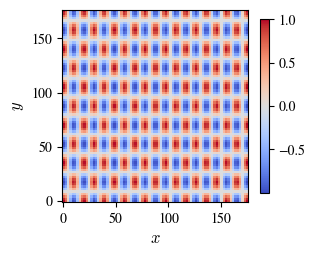

In [ ]:
# MAKE V TERMS?
V_TERMS = True

if V_TERMS:
  freq = 2*np.pi/175

  # Form 2D cosine series terms
  V_nm = lambda n,m: torch.cos(freq*n*X2) * torch.cos(freq*m*Y2)
  Vx_nm = lambda n,m: -(freq*n) * torch.sin(freq*n*X2) * torch.cos(freq*m*Y2)
  Vy_nm = lambda n,m: -(freq*m) * torch.cos(freq*n*X2) * torch.sin(freq*m*Y2)

  # Build weak gradients
  kernel_x = model.kernels[2]
  kernel_y = model.kernels[4]

  UVx_nm = lambda n,m: U_ws * Vx_nm(n,m).unsqueeze(2)
  UVy_nm = lambda n,m: U_ws * Vy_nm(n,m).unsqueeze(2)
  psix_UVx_nm = lambda n,m: compute_weak_poly(UVx_nm(n,m), kernel_x, model.spacing)
  psiy_UVy_nm = lambda n,m: compute_weak_poly(UVy_nm(n,m), kernel_y, model.spacing)

  weak_Vnm_term = lambda n,m: psix_UVx_nm(n,m) + psix_UVx_nm(n,m)

  # Construct Vnm terms and add to library
  [N,M] = [9,9]
  NMs = list(itertools.product(range(1,N+1), range(1,M+1)))

  for n,m in NMs:
    term = weak_Vnm_term(n,m)
    G.append(term[model.conv_mask])
    name = '∇·(u∇V_{' + f'{n}{m}' + '})'
    rhs_names.append(name)

  # Print out new symbolic library
  lib_string = r'\Theta='+r'\{'+r',\,'.join(rhs_names[:-len(NMs)+2])+r',\,\dots\,\}'
  display(Math(lib_string))

  G_mat = torch.stack(G).T
  print(f'Library shape: G = {G_mat.numpy().shape}')
  print(f'Condition number: K(G) = {la.cond(G_mat):.2e}\n')

  # Check aliasing?
  plt.figure(figsize=(3,2.5))
  plt.pcolormesh(X2, Y2, V_nm(9,5), cmap='coolwarm')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.colorbar(shrink=0.9)
  plt.show()

\begin{align*}
\mathcal{K}(r) = \sum_{n=0}^N \, \beta_n \, \mathcal{K}_n(r) := \sum_{n=0}^N \, \beta_n \, j_n(r/s)
\end{align*}

In [ ]:
from scipy.special import spherical_jn

# MAKE K TERMS?
K_TERMS = False

if K_TERMS:
  # Pick a U-scale
  slicer = (slice(model.m[0],-model.m[0]),
            slice(model.m[1],-model.m[1]),
            slice(model.m[2],-model.m[2]))
  Uc = U_ws[slicer].max().item()
  print(f'Uc = {Uc:.2e}')

  scale = 6 # scale (s) for j_n(r/s)
  mult = 1/Uc

  # Radial grid for K(|x-x0|)
  K_slice = (slice(30,-30,None), slice(30,-30,None))

  XK = (X2[K_slice] - Nx*dx/2).numpy()
  YK = (Y2[K_slice] - Ny*dy/2).numpy()
  RK = np.sqrt(XK**2 + YK**2)
  RK_inv = np.minimum(1/RK, 1)

  # Form spherical Bessel terms
  K_n = lambda n: mult*spherical_jn(n, RK/scale)
  Kx_n = lambda n: mult*(XK*RK_inv/scale) * spherical_jn(n, RK/scale, derivative=True)
  Ky_n = lambda n: mult*(YK*RK_inv/scale) * spherical_jn(n, RK/scale, derivative=True)

  # Build convolution terms
  KxU_n = lambda n: convolve(U_ws, Kx_n(n)[:,:,np.newaxis], mode='same')
  KyU_n = lambda n: convolve(U_ws, Ky_n(n)[:,:,np.newaxis], mode='same')

  # Build weak gradients
  UKxU_n = lambda n: U_ws * torch.from_numpy(KxU_n(n))
  UKyU_n = lambda n: U_ws * torch.from_numpy(KyU_n(n))
  psix_UKxU_n = lambda n: compute_weak_poly(UKxU_n(n), kernel_x, model.spacing)
  psiy_UKyU_n = lambda n: compute_weak_poly(UKyU_n(n), kernel_y, model.spacing)

  weak_Kn_term = lambda n: psix_UKxU_n(n) + psiy_UKyU_n(n)

  # Construct Kn terms and add to library
  NK = 5
  for n in range(NK):
    term = weak_Kn_term(n)
    G.append(term[model.conv_mask])
    name = '∇·u(∇K_{' + f'{n}' + '}*u)'
    rhs_names.append(name)

  # Print out new symbolic library
  lib_string = lib_string[:-2]+','+r',\,'.join(rhs_names[-NK:-NK+2])+r',\dots\}'
  display(Math(lib_string))

  G_mat = torch.stack(G).T
  print(f'Library shape: G = {G_mat.numpy().shape}')
  print(f'Condition number: K(G) = {la.cond(G_mat):.2e}\n')

  # Check it out
  plt.figure(figsize=(3,2.5))
  plt.pcolormesh(XK, YK, K_n(0), cmap='coolwarm')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title('$U^{-1}_c j_0(r/s)$')
  plt.colorbar(shrink=0.9)
  plt.show()

Solve for model weights

In [ ]:
# Set library
model.set_library(G, powers, derivs, rhs_names)

# Find sparse weights
w = model.MSTLS()
model.print_report()

HYPER-PARAMETERS
m = [10, 10, 6]
p = [14, 14, 20]
s = [1, 1, 1]
Not rescaled.

LIBRARY
Num. query points = 309600
Num. terms = 84
cond(G) = 1.579e+04

RESULTS
PDE: u_{t} = + 8.61(u)_{xx} + 9.08(u)_{yy} - 5.55∇·(u∇V_{14}) - 7.21∇·(u∇V_{15}) + 0.23∇·(u∇V_{52})
Nonzero terms = 5
Rel. L2 error = 0.575
R^2 = 0.669
Lambda = 8.685e-02
Loss = 0.276


Examine model

In [ ]:
print('Sparse diffusion constants:')
if len(w) == 1:
  print(f'Deff = {w[0].item():.1f}')
else:
  print(f'Dx = {w[0].item():.1f}')
  print(f'Dxy = {(w[2]/2).item():.1f}')
  print(f'Dy = {w[1].item():.1f}')
  print(f'Dx/Dy = {(w[0]/w[1]).item():.2f}')

Sparse diffusion constants:
Dx = 8.6
Dxy = 0.0
Dy = 9.1
Dx/Dy = 0.95


<IPython.core.display.Math object>

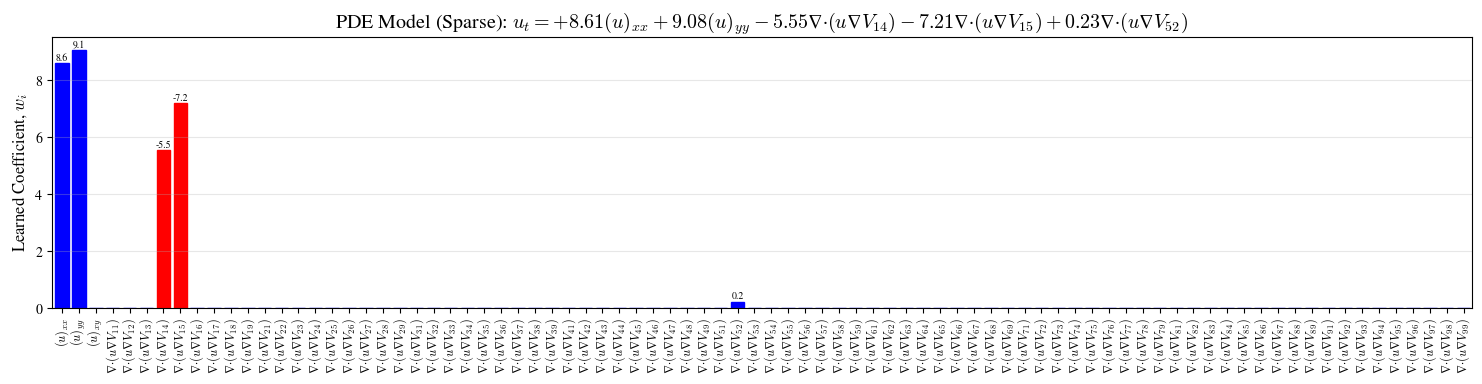

In [ ]:
# Print sparse PDE
pde = symbolic_pde(model.lhs_name, model.rhs_names, model.coeffs)
display(Math(pde))

# Plot the sparse coefficients
coeffs = model.coeffs.clone().numpy()
term_names = model.rhs_names

plt.figure(figsize=(15, 4))
bars = plt.bar(range(len(coeffs)), np.abs(coeffs))
plt.ylabel('Learned Coefficient, $w_i$')
#plt.title('PDE Model (Sparse)')
plt.title(f'PDE Model (Sparse): ${pde}$')
plt.xticks(range(len(term_names)), [f'${name}$' for name in term_names],
           rotation=90, fontsize=9)
plt.xlim(-0.6, len(coeffs) - 0.5)

for i,(bar,coeff) in enumerate(zip(bars,coeffs)):
  if coeff >= 0:
    bar.set_color('blue')
  else:
    bar.set_color('red')

for i,(bar,coeff) in enumerate(zip(bars,coeffs)):
  if abs(coeff) > 1e-6:
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
             f'{coeff:.1f}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
# Compare to LS solution
w_LS = la.lstsq(torch.stack(G).T, model.lhs).solution
r_LS = (model.lhs - model.library @ w_LS).clone()
bbar = model.lhs.mean().clone()
R2_LS = 1 - (r_LS @ r_LS) / ((model.lhs - bbar) @ (model.lhs - bbar))
print(f'LS soln R^2: {R2_LS:.3f}')

print('LS diffusion constants:')
if len(w_LS) == 1:
  print(f'Deff = {w_LS[0].item():.1f}')
else:
  print(f'Dx = {w_LS[0].item():.1f}')
  print(f'Dxy = {(w_LS[2]/2).item():.1f}')
  print(f'Dy = {w_LS[1].item():.1f}')
  print(f'Dx/Dy = {(w_LS[0]/w_LS[1]).item():.2f}')

LS soln R^2: 0.702
LS diffusion constants:
Dx = 7.4
Dxy = 1.0
Dy = 8.4
Dx/Dy = 0.88


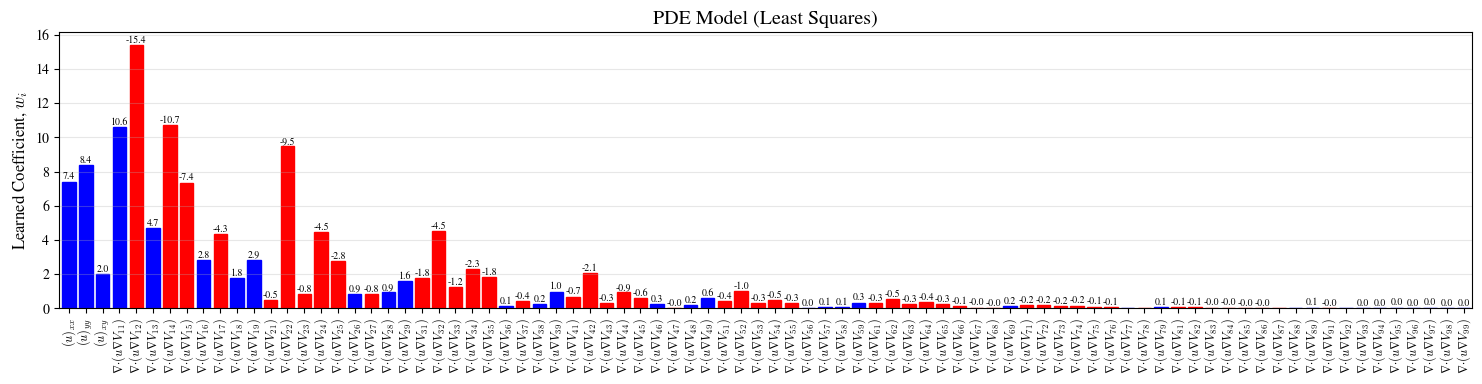

In [ ]:
# Plot the LS coefficients
coeffs = w_LS.clone().numpy()
term_names = model.rhs_names

plt.figure(figsize=(15, 4))
bars = plt.bar(range(len(coeffs)), np.abs(coeffs))
plt.ylabel('Learned Coefficient, $w_i$')
plt.title('PDE Model (Least Squares)')
plt.xticks(range(len(term_names)), [f'${name}$' for name in term_names],
           rotation=90, fontsize=9)
plt.xlim(-0.6, len(coeffs) - 0.5)

for i,(bar,coeff) in enumerate(zip(bars,coeffs)):
  if coeff >= 0:
    bar.set_color('blue')
  else:
    bar.set_color('red')

for i,(bar,coeff) in enumerate(zip(bars,coeffs)):
  if abs(coeff) > 1e-2:
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
             f'{coeff:.1f}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

\begin{align*}
{\rm{AIC}}(\mathbf{r}, \mathbf{w}) &= 2\lvert\!\lvert \mathbf{w} \rvert\!\rvert_{0} + N\ln\!\big(|\mathbf{r}|^2\big)
\end{align*}

In [ ]:
# Nonzero parameters
ws_terms = w.nonzero().shape[0]
LS_terms = w_LS.nonzero().shape[0]

# Sparse AIC
r_ws = (model.lhs - model.library @ model.coeffs).clone()
AIC_ws = 2*ws_terms + N_data*np.log((r_ws@r_ws).item())
print(f'Sparse AIC = {AIC_ws:.1f}')

# Least squares AIC
AIC_LS = 2*LS_terms + N_data*np.log((r_LS@r_LS).item())
print(f'LS AIC = {AIC_LS:.1f}')

# Comparative AIC
print(f'Delta AIC = {AIC_ws - AIC_LS:.2f}')
print(f'Rel. likelihood = {np.exp((AIC_ws - AIC_LS)/2):.3e}')

Sparse AIC = -3177.4
LS AIC = -3120.5
Delta AIC = -56.94
Rel. likelihood = 4.320e-13


Standard errors for parameters \begin{align*}
\hat{\sigma}(w_j) = \sqrt{\hat{\mathbf{S}}_{jj}},
\quad \text{where} \quad
\hat{\mathbf{S}} = \mathbf{G}^{\dagger} \, \text{diag}\big(r^2_1, \dots, r^2_{\kappa}\big) \big(\mathbf{G}^{\dagger}\big)^T
\end{align*}

In [ ]:
# PROPAGATE UNCERTAINTY
for choice in ['WSINDy', 'LS']:

  # Full parameter covariance matrix
  if choice == 'WSINDy':
    print('Sparse uncertainties:')
    nonzero_inds = w.nonzero().reshape(-1).tolist()
    w_prime = w.clone()
    G_prime = model.library[:,nonzero_inds].clone()
    r_prime = r_ws.clone()
  elif choice == 'LS':
    print('\nLS uncertainties:')
    nonzero_inds = w_LS.nonzero().reshape(-1).tolist()
    w_prime = w_LS.clone()
    G_prime = model.library[:,nonzero_inds].clone()
    r_prime = r_LS.clone()

  G_dagger = la.pinv(G_prime)
  S = G_dagger @ ((r_prime**2).unsqueeze(1) * G_dagger.T)
  sigmas = torch.sqrt(torch.diag(S))

  # Effective model
  if len(model.rhs_names) == 1:
    print(f'{model.rhs_names[0]} = {w[0].item():.1f} +/- {2*sigmas[0].item():.1f}')
    break

  # Anisotropic model
  if len(model.rhs_names) == 3:
    print(f'{model.rhs_names[0]} = {w[0].item():.1f} +/- {2*sigmas[0].item():.1f}')
    print(f'{model.rhs_names[1]} = {w[1].item():.1f} +/- {2*sigmas[1].item():.1f}')
    print(f'{model.rhs_names[2]} = {w[2].item()/2:.1f} +/- {2*sigmas[2].item():.1f}')
    break

  # Full model
  if len(model.rhs_names) >= 3 + (N*M):
    print(f'{model.rhs_names[0]} = {w[0].item():.1f} +/- {2*sigmas[0].item():.1f}')
    print(f'{model.rhs_names[1]} = {w[1].item():.1f} +/- {2*sigmas[1].item():.1f}')
    print(f'{model.rhs_names[2]} = {w[2].item()/2:.1f} +/- {2*sigmas[2].item():.1f}')

    if V_TERMS:
      dV_x = torch.zeros_like(X2)
      dV_y = torch.zeros_like(Y2)
      for i,ind in enumerate(w_prime[3:3+(N*M)].nonzero().reshape(-1).tolist()):
        nm = NMs[ind]
        s0 = len(w_prime[0:3].nonzero())
        dV_x += 2*sigmas[s0+i]*Vx_nm(*nm)
        dV_y += 2*sigmas[s0+i]*Vy_nm(*nm)
      dVc = torch.sqrt(dV_x**2 + dV_y**2)
      dVc = dVc[model.m[0]:-model.m[0], model.m[1]:-model.m[1]].max().item()
      print(f'Vc uncertainty = +/- {dVc:.1f}')

    if K_TERMS:
      dK_x = torch.zeros(20,20)
      dK_y = torch.zeros(20,20)
      for i,ind in enumerate(w_prime[3+(N*M):].nonzero().reshape(-1).tolist()):
        n = [n for n in range(NK)][ind]
        s0 = len(w_prime[0:3+(N*M)].nonzero())
        dK_x += 2*sigmas[s0+i]*torch.from_numpy(Kx_n(n))
        dK_y += 2*sigmas[s0+i]*torch.from_numpy(Ky_n(n))
      dKc = torch.sqrt((Uc*dK_x)**2 + (Uc*dK_y)**2)
      dKc = dKc.max().item()
      print(f'Kc uncertainty = +/- {dKc:.1f}')

Sparse uncertainties:
(u)_{xx} = 8.6 +/- 0.2
(u)_{yy} = 9.1 +/- 0.2
(u)_{xy} = 0.0 +/- 0.3
Vc uncertainty = +/- 0.1

LS uncertainties:
(u)_{xx} = 8.6 +/- 0.3
(u)_{yy} = 9.1 +/- 0.2
(u)_{xy} = 0.0 +/- 0.3
Vc uncertainty = +/- 1.0


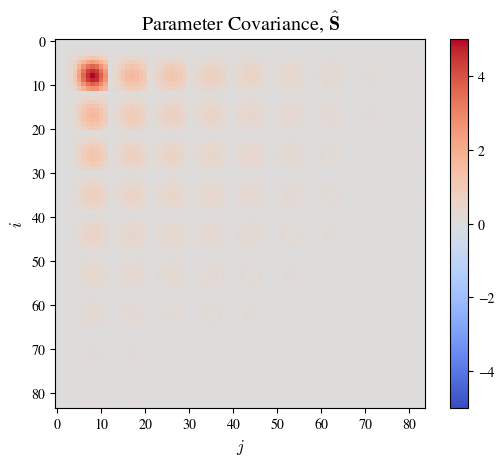

In [ ]:
from matplotlib.ticker import MaxNLocator

# Visualize parameter covariance matrix
plt.imshow(S, cmap='coolwarm', vmin=-abs(S).max(), vmax=abs(S).max())
plt.xlabel('$j$')
plt.ylabel('$i$')
plt.title(r'Parameter Covariance, $\hat{\mathbf{S}}$')
plt.colorbar()
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

Leptokurtosis in equation residuals

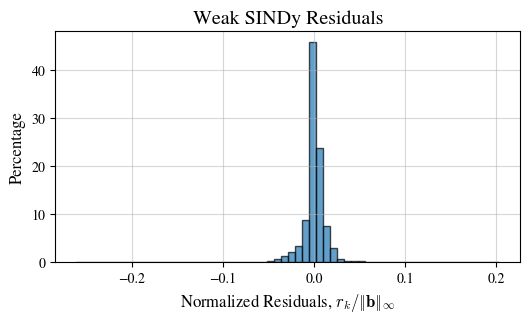

In [ ]:
# Plot residuals, r = b - G*w
b_inf = abs(model.lhs).max().item()
weights = 100*torch.ones_like(r_ws)/len(r_ws)

plt.figure(figsize=(6,3))
plt.hist(r_ws/b_inf, bins=60, edgecolor='k', alpha=0.7, weights=weights)
plt.xlabel(r'Normalized Residuals, $r_k/|\!|\mathbf{b}|\!|_{\infty}$')
plt.ylabel('Percentage')
plt.title('Weak SINDy Residuals')
plt.grid(True, alpha=0.5)
#plt.yscale('log')
plt.show()

Visualize weak form features and residuals

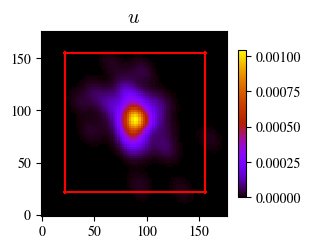

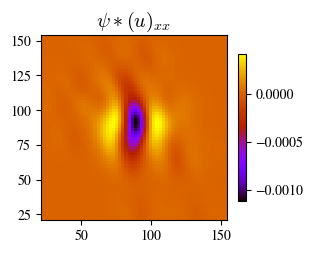

In [ ]:
# Weak form representations
thyme = 1
m = model.m
slicer = tuple([U_ws.shape[i] - 2*m[i] for i in range(len(m))])

# Original data
plt.figure(figsize=(3,2.4))
coords = (X[:,:,0], Y[:,:,0])
plt.pcolormesh(*coords, U_ws[:,:,m[2]+thyme], cmap='gnuplot')

xbox = [x[m[0]].item()/175, x[-m[0]].item()/175]
ybox = [y[m[1]].item()/175, y[-m[1]].item()/175]
plt.axhline(y=y[m[1]], xmin=xbox[0], xmax=xbox[1], color='red')
plt.axhline(y=y[-m[1]], xmin=xbox[0], xmax=xbox[1], color='red')
plt.axvline(x=x[m[0]], ymin=ybox[0], ymax=ybox[1], color='red')
plt.axvline(x=x[-m[0]], ymin=ybox[0], ymax=ybox[1], color='red')

plt.title(f'$u$')
plt.colorbar(shrink=0.8)
plt.show()

# Weak form
plt.figure(figsize=(3,2.4))
coords = (X[m[0]:-m[0], m[1]:-m[1], 0], Y[m[0]:-m[0], m[1]:-m[1], 0])
plt.pcolormesh(*coords, G[0].reshape(slicer)[:,:,thyme], cmap='gnuplot')
plt.title(f'$\\psi * {model.rhs_names[0]}$')
plt.colorbar(shrink=0.8)
plt.show()

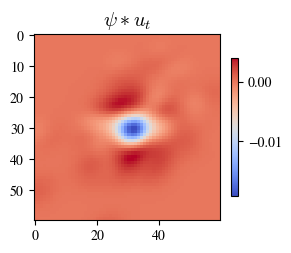

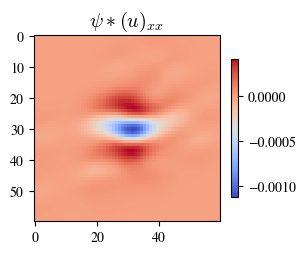

In [ ]:
# More weak form features
lib_index = 0
thyme = 1

plt.figure(figsize=(3,3))
plt.imshow(model.lhs.reshape(slicer)[:,:,thyme], cmap='coolwarm')
plt.title(f'$\\psi * {model.lhs_name}$')
plt.colorbar(shrink=0.6)
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(G[lib_index].reshape(slicer)[:,:,thyme], cmap='coolwarm')
plt.title(f'$\\psi * {model.rhs_names[lib_index]}$')
plt.colorbar(shrink=0.6)
plt.show()

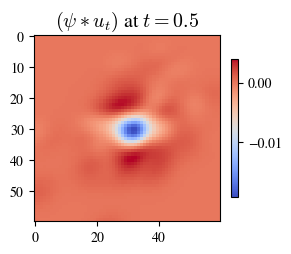

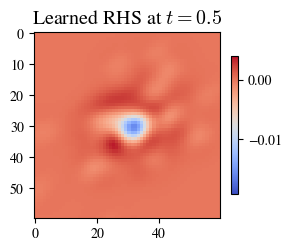

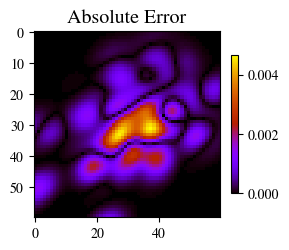

In [ ]:
# Weak form model
RHS = (model.library @ model.coeffs)
thyme = 1

plotz = {'cmap': 'coolwarm',
         'vmin': model.lhs.reshape(slicer)[:,:,thyme].min(),
         'vmax': model.lhs.reshape(slicer)[:,:,thyme].max()}

plt.figure(figsize=(3,3))
plt.imshow(model.lhs.reshape(slicer)[:,:,thyme], **plotz)
plt.title(f'$(\\psi * {model.lhs_name})$ at $t={t_new[thyme]:.1f}$')
plt.colorbar(shrink=0.6)
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(RHS.reshape(slicer)[:,:,thyme], **plotz)
plt.title(f'Learned RHS at $t={t_new[thyme]:.1f}$')
plt.colorbar(shrink=0.6)
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(abs(model.lhs-RHS).reshape(slicer)[:,:,thyme], cmap='gnuplot')
plt.title(f'Absolute Error')
plt.colorbar(shrink=0.6)
plt.show()

Visualize potentials

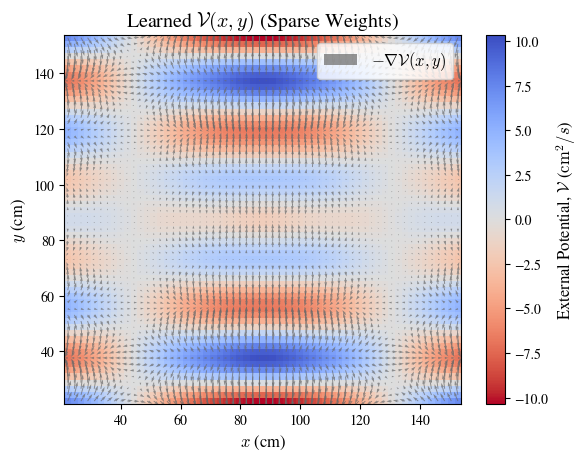

In [ ]:
# EXTERNAL POTENTIAL (SPARSE)
if V_TERMS:
  if K_TERMS:
    V_inds = [ind[0] for ind in w[6:-NK].nonzero().tolist()]
    V_NMs = [NMs[ind] for ind in V_inds]
    V_coeffs = [w[6:-NK][ind].item() for ind in V_inds]
  else:
    V_inds = [ind[0] for ind in w[3:].nonzero().tolist()]
    V_NMs = [NMs[ind] for ind in V_inds]
    V_coeffs = [w[3:][ind].item() for ind in V_inds]

  # Construct V
  V0 = np.zeros_like(X2)
  V = V0 + np.add.reduce([V_coeffs[i]*V_nm(*V_NMs[i]) for i in range(len(V_coeffs))])
  Vx = V0 + np.add.reduce([V_coeffs[i]*Vx_nm(*V_NMs[i]) for i in range(len(V_coeffs))])
  Vy = V0 + np.add.reduce([V_coeffs[i]*Vy_nm(*V_NMs[i]) for i in range(len(V_coeffs))])

  if V_inds != []:
    slicer = (slice(m[0],-m[0]),slice(m[1],-m[1]))
    plt.pcolormesh(X2[slicer], Y2[slicer], V[slicer], cmap='coolwarm_r',
                  vmin=-abs(V[slicer]).max(), vmax=abs(V[slicer]).max())
    plt.colorbar(label=r'External Potential, $\mathcal{V}$ ($\text{cm}^2/s$)')
    plt.quiver(X2[slicer], Y2[slicer], -Vx[slicer], -Vy[slicer],
              angles='xy', scale_units='xy', scale=1/5,
              color='dimgrey', alpha=0.7, label=r'$-\nabla\mathcal{V}(x,y)$')
    plt.xlabel('$x$ (cm)')
    plt.ylabel('$y$ (cm)')
    plt.title('Learned $\\mathcal{V}(x,y)$ (Sparse Weights)')
    plt.legend(loc='upper right')
    plt.show()
  else:
    print('Sparse V = 0')

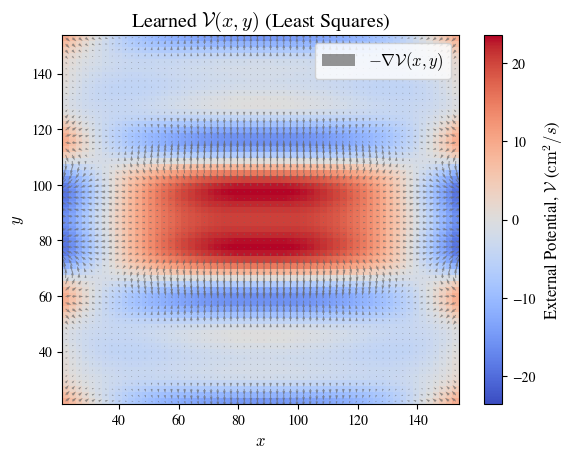

In [ ]:
# EXTERNAL POTENTIAL (LS)
if V_TERMS:
  if K_TERMS:
    V_LS_coeffs = w_LS[6:-NK].tolist()
    V_LS_coeffs = w_LS[4:-NK].tolist()
    V_LS_coeffs = w_LS[3:-NK].tolist()
  else:
    V_LS_coeffs = w_LS[3:].tolist()

  # Construct V_LS
  V_LS = V0 + np.add.reduce([V_LS_coeffs[i] * V_nm(*nm) for i,nm in enumerate(NMs)])
  Vx_LS = V0 + np.add.reduce([V_LS_coeffs[i] * Vx_nm(*nm) for i,nm in enumerate(NMs)])
  Vy_LS = V0 + np.add.reduce([V_LS_coeffs[i] * Vy_nm(*nm) for i,nm in enumerate(NMs)])

  slicer = (slice(m[0],-m[0]), slice(m[1],-m[1]))
  plt.pcolormesh(X2[slicer], Y2[slicer], V_LS[slicer], cmap='coolwarm',
                vmin=-abs(V_LS[slicer]).max(), vmax=abs(V_LS[slicer]).max())
  plt.colorbar(label=r'External Potential, $\mathcal{V}$ ($\text{cm}^2/s$)')
  plt.quiver(X2[slicer], Y2[slicer], -Vx_LS[slicer], -Vy_LS[slicer],
              angles='xy', scale_units='xy', #scale=1/2,
              color='dimgrey', alpha=0.7, label=r'$-\nabla\mathcal{V}(x,y)$')

  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title('Learned $\\mathcal{V}(x,y)$ (Least Squares)')
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
# Pick V constant
if V_TERMS:
  Vc = np.sqrt(Vx[slicer]**2 + Vy[slicer]**2).max().item()
  Vc_LS = np.sqrt(Vx_LS[slicer]**2 + Vy_LS[slicer]**2).max().item()

  print(f'Sparse: Vc = {Vc:.1f}')
  print(f'Least squares: Vc = {Vc_LS:.1f}')

Sparse: Vc = 1.8
Least squares: Vc = 3.6


In [ ]:
# INTERACTION POTENTIAL (SPARSE)
if K_TERMS:
  K_inds = [ind[0] for ind in w[-NK:].nonzero().tolist()]
  K_Ns = [ind for ind in K_inds]
  K_coeffs = [w[-NK:][ind].item() for ind in K_inds]

  # Construct K
  K0 = np.zeros_like(XK)
  K = K0 + np.add.reduce([K_coeffs[i] * K_n(K_Ns[i]) for i in range(len(K_coeffs))])
  Kx = K0 + np.add.reduce([K_coeffs[i] * Kx_n(K_Ns[i]) for i in range(len(K_coeffs))])
  Ky = K0 + np.add.reduce([K_coeffs[i] * Ky_n(K_Ns[i]) for i in range(len(K_coeffs))])

  if K_inds != []:
    #plt.pcolormesh(XK, YK, K, cmap='coolwarm_r')
    plt.pcolormesh(XK, YK, K-K.mean(), cmap='coolwarm_r')
    plt.colorbar(label=r'Interaction Potential, $\mathcal{K}$ ($\text{cm}^2/s$)')
    plt.quiver(XK, YK, -Kx, -Ky, color='dimgrey', label=r'$-\nabla\mathcal{K}(\rho)$')
    plt.xlabel('$x$ (cm)')
    plt.ylabel('$y$ (cm)')
    plt.title(r'Learned $\mathcal{K}(\rho)$ (Sparse Weights)')
    plt.legend(loc='upper right')
    plt.show()
  else:
    print('Sparse K = 0')

In [ ]:
# INTERACTION POTENTIAL (LS)
if K_TERMS:
  K_LS_coeffs = w_LS[-NK:].tolist()

  # Construct K_LS
  K_LS = K0 + np.add.reduce([K_LS_coeffs[n] * K_n(n) for n in range(len(K_LS_coeffs))])
  Kx_LS = K0 + np.add.reduce([K_LS_coeffs[n] * Kx_n(n) for n in range(len(K_LS_coeffs))])
  Ky_LS = K0 + np.add.reduce([K_LS_coeffs[n] * Ky_n(n) for n in range(len(K_LS_coeffs))])

  #plt.pcolormesh(XK, YK, K_LS, cmap='coolwarm_r')
  #plt.pcolormesh(XK, YK, Uc*K_LS, cmap='coolwarm_r')
  plt.pcolormesh(XK, YK, Uc*(K_LS-K_LS.mean()), cmap='coolwarm_r')
  plt.colorbar(label=r'Interaction Potential, $\mathcal{K}$ ($\text{cm}^2/s$)')
  plt.quiver(XK, YK, -Kx_LS, -Ky_LS, color='dimgrey', label=r'$-\nabla\mathcal{K}(\rho)$')
  plt.xlabel('$x$ (cm)')
  plt.ylabel('$y$ (cm)')
  plt.title(r'Learned $\mathcal{K}(\rho)$ (Least Squares)')
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
# Pick K constant
if K_TERMS:
  Kc = np.sqrt((Uc*Kx)**2 + (Uc*Ky)**2).max().item()
  Kc_LS = np.sqrt((Uc*Kx_LS)**2 + (Uc*Ky_LS)**2).max().item()
  print(f'Sparse: Kc = {Kc:.2f}')
  print(f'Least squares: Kc = {Kc_LS:.2f}')

# Simulations

In [ ]:
from scipy.special import spherical_jn

class McKeanVlasovSimulator:
  def __init__(self, N=100, L=175, A=1.0, B=1.0):
    self.N = N
    self.L = L
    self.A = A
    self.B = B

    self.ks = [(1,4), (1,5), (5,2)] # (kx,ky) pairs for Vnm modes
    self.V_coeffs = [-5.55/12.53, -7.21/12.53, 0.23/12.53] # V14, V15, V52
    self.K_coeffs = [0.0, -1.0, 0.0] # j0, j1, j2

    rng = np.random.default_rng(42)
    #self.positions = rng.normal(self.L/2, 5, (N,2))
    self.positions = rng.normal(self.L/2, 8, (N,2))
    self.trajectory = []

  # ------------------ TERMS ------------------
  def potential_V(self, x, y):
    V = 0
    for i,(kx,ky) in enumerate(self.ks):
      Anm = self.V_coeffs[i]
      V += Anm * np.cos(2*np.pi*kx*x/self.L) * np.cos(2*np.pi*ky*y/self.L)
    return self.A * V

  def gradient_V(self, x, y):
    dVdx = 0
    dVdy = 0
    for i,(kx,ky) in enumerate(self.ks):
      Anm = self.V_coeffs[i]
      dVdx += -Anm*kx * np.sin(2*np.pi*kx*x/self.L) * np.cos(2*np.pi*ky*y/self.L)
      dVdy += -Anm*ky * np.cos(2*np.pi*kx*x/self.L) * np.sin(2*np.pi*ky*y/self.L)
    return self.A * np.array([dVdx, dVdy])

  def potential_K(self, r, r0=6):
    if r == 0:
      return 0
    K_val = 0
    for n, a_n in enumerate(self.K_coeffs):
      K_val += a_n * spherical_jn(n, r/r0)
    return self.B * K_val

  def K_prime(self, r, r0=6):
    if r == 0:
      return 0
    dKdr_val = 0
    for n, a_n in enumerate(self.K_coeffs):
      dKdr_val += (a_n/r0) * spherical_jn(n, r/r0, derivative=True)
    return self.B * dKdr_val

  def gradient_K(self, i):
    xi = self.positions[i]
    force = np.zeros(2)

    for j in range(self.N):
      if j != i:
        xj = self.positions[j]
        diff = xi - xj
        r = np.linalg.norm(diff)
        if r > 0:
          dKdr_val = self.K_prime(r)
          force += (diff/r) * dKdr_val
    return force

  # ------------------ SIMULATION ------------------
  def euler_step(self, dt=0.01):
    new_positions = np.zeros_like(self.positions)

    for i in range(self.N):
      x, y = self.positions[i]
      grad_V = self.gradient_V(x, y)
      grad_K = self.gradient_K(i)
      dB = np.random.normal(0, np.sqrt(dt), 2) # sigma = sqrt(dt)

      # SDE: dx = -(A*grad_V + B*sum(grad_K)) + sqrt(2)*dB
      drift = -(grad_V + grad_K)
      diffusion = np.sqrt(2)*dB
      new_positions[i] = self.positions[i] + drift*dt + diffusion

    # Apply periodic BCs
    self.positions = new_positions
    self.positions = np.mod(self.positions + self.L, self.L)

  def simulate(self, T=10, dt=0.01, save_interval=10):
    n_steps = int(T / dt)
    self.trajectory = [self.positions.copy()]

    print(f"Running simulation for {n_steps} steps...")

    for step in range(n_steps):
      self.euler_step(dt)
      if step % save_interval == 0:
        self.trajectory.append(self.positions.copy())
      if step % 1000 == 0:
        print(f"Step {step}/{n_steps}")

    print("Simulation complete!")

  # ------------------ PLOTTING ------------------
  def plot_V_potential(self, ax, resolution=200, cbar=True):
    x = np.linspace(0, self.L, resolution)
    y = np.linspace(0, self.L, resolution)
    X,Y = np.meshgrid(x, y)

    # Scalar field
    V = self.potential_V(X,Y)
    extent = [0, self.L]
    im = ax.imshow(V, extent=2*extent, origin='lower', cmap='RdBu', alpha=0.8,
                   #vmin=-self.A, vmax=self.A)
                   vmin=-1.0, vmax=1.0)

    # Vector field
    arrow_spacing = 45
    x_arrows = np.linspace(0, self.L, arrow_spacing)
    y_arrows = np.linspace(0, self.L, arrow_spacing)
    X_arrows, Y_arrows = np.meshgrid(x_arrows, y_arrows)

    grad_V = self.gradient_V(X_arrows, Y_arrows)
    grad_x = grad_V[0]
    grad_y = grad_V[1]
    ax.quiver(X_arrows, Y_arrows, -grad_x, -grad_y,
              angles='xy', scale_units='xy', scale=1/2,
              color='gray', alpha=0.7, label=r'$-\nabla\mathcal{V}$')
    ax.set_xlim(0, self.L)
    ax.set_ylim(0, self.L)
    if cbar:
      ax.set_xlabel('$x$ (cm)')
      ax.set_ylabel('$y$ (cm)')
      ax.legend(fontsize=10)
      cbar = plt.colorbar(im, ax=ax, shrink=0.72)
      cbar.set_label(r'External Potential, $\mathcal{V}$ ($\text{cm}^2/s$)')
    return im

  def plot_K_potential(self, ax, r_max=30, resolution=1000, cbar=True):
    r = np.linspace(0.1, r_max, resolution)
    K_vals = [self.potential_K(r_i) for r_i in r]
    K_prime_vals = [-self.K_prime(r_i) for r_i in r]

    ax.plot(r, K_vals, 'b-', linewidth=2, zorder=2,
            label=r'$+\mathcal{K}(\rho)$ ($\text{cm}^2/s$)')
    ax.plot(r, K_prime_vals, 'r-', linewidth=2, zorder=2,
            label=r"$-\mathcal{K}'(\rho)$ ($\text{cm}/s$)")
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, zorder=1)

    # 1D vector field of -K'(r)
    step = max(1, resolution//12)
    rs = r[::step]
    Kps = K_prime_vals[::step]

    ax.quiver(rs, np.zeros_like(rs), Kps, np.zeros_like(rs),
              scale=1/1e3, angles='xy', scale_units='xy',
              width=0.012, headwidth=4, headlength=6,
              color='dimgrey', alpha=0.7, zorder=10)
    ax.set_ylim([-0.025, 0.006])
    ax.grid(True, alpha=0.6)
    if cbar:
      ax.set_xlabel(r'Distance, $\rho$ (cm)')
      ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

  def plot_final_state(self, ax, show_trajectories=True, cbar=True):
    im = self.plot_V_potential(ax, cbar=cbar)

    if show_trajectories and len(self.trajectory) > 1:
      for i in range(self.N):
        trajectory = np.array([pos[i] for pos in self.trajectory])
        ax.plot(trajectory[:,0], trajectory[:,1], 'k-', alpha=0.5, lw=1.5)

    ax.scatter(self.positions[:,0], self.positions[:,1], c='k', s=15, alpha=0.8)
    ax.set_title(f'$\\Pi_V = {self.A:.1f}$ and $\\Pi_K={self.B:.1e}$')

    # Inset panel ----
    bbox = [0.02, 0.76, 0.65, 0.22]  # [x0, y0, W, H]
    inset_ax = ax.inset_axes(bbox)

    r_max = 30
    resolution = 800
    r = np.linspace(0.1, r_max, resolution)
    K_vals = np.array([self.potential_K(r_i) for r_i in r])
    K_prime_vals = np.array([-self.K_prime(r_i) for r_i in r])

    # Plot K and -K'
    #inset_ax.plot(r, K_vals, '-', lw=1.6, zorder=2,
    #              label=r'$+\mathcal{K}(\rho)$ ($\text{cm}^2/s$)')
    inset_ax.plot(r, K_prime_vals, '-', lw=1.6, zorder=2,
                  label=r"$-\mathcal{K}'(\rho)$ ($\text{cm}/s$)")
    inset_ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, zorder=1)

    # 1D vector field arrows (subsample)
    step = max(1, resolution//12)
    rs = r[::step]
    Kps = K_prime_vals[::step]
    inset_ax.quiver(rs, np.zeros_like(rs), Kps, np.zeros_like(rs),
                    #scale=1/(1e3), angles='xy', scale_units='xy',
                    scale=0.003, angles='xy', scale_units='xy',
                    width=0.012, headwidth=4, headlength=6,
                    color='dimgrey', alpha=0.7, zorder=10)

    # if cbar:
    #   inset_ax.set_xlabel(r'Distance, $\rho$ (cm)', fontsize=10)
    #   inset_ax.legend(fontsize=9, loc='lower right', framealpha=0.7)
    inset_ax.set_xlabel(r'Distance, $\rho$ (cm)', fontsize=10)
    inset_ax.legend(fontsize=9, loc='upper right', framealpha=0.7)
    inset_ax.set_yscale('symlog', linthresh=5e-1)
    #inset_ax.set_ylim([-self.B/2, self.B/2])
    #inset_ax.set_ylim([-0.025, 0.006])
    inset_ax.set_ylim([-3*0.004, 3*0.004])
    inset_ax.set_xlim(0, min(r_max, r.max()))
    inset_ax.grid(True, alpha=0.5)
    inset_ax.tick_params(axis='both', which='major', labelsize=9)

    # Move axis ticks etc.
    inset_ax.yaxis.set_ticks_position('right')
    inset_ax.yaxis.set_label_position('right')
    inset_ax.tick_params(axis='y', labelleft=False, labelright=True, direction='in')
    inset_ax.tick_params(axis='x', direction='in')
    # ------------------

    plt.tight_layout()
    plt.show()

A=1.000, B=0.050


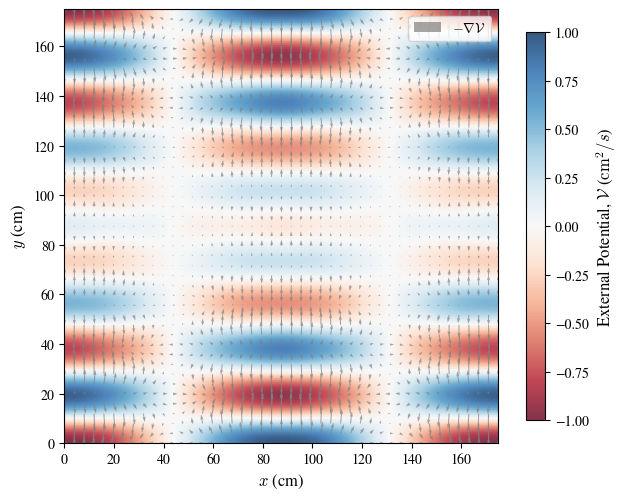

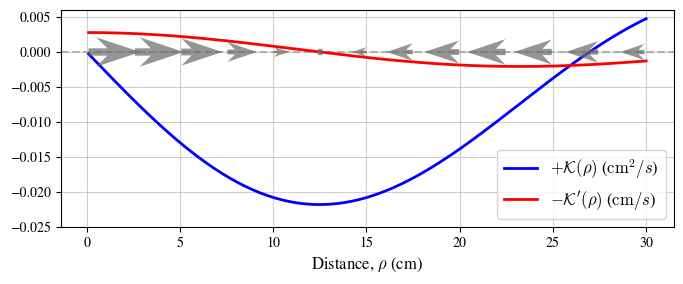

In [ ]:
# Create simulator
[Vc, D, Uc, Kc, tc] = [1., 1., 5.e-2, 1, 1.]
A = Vc/D
B = Uc*Kc*tc
sim = McKeanVlasovSimulator(N=20, L=175, A=A, B=B)
print(f'A={sim.A:.3f}, B={sim.B:.3f}')

# Double-check potentials
fig,ax = plt.subplots(1,1, figsize=(7,7))
im = sim.plot_V_potential(ax, resolution=200, cbar=True)

fig,ax = plt.subplots(1,1, figsize=(7,3))
sim.plot_K_potential(ax, r_max=30, resolution=1000, cbar=True)

Running simulation for 10 steps...
Step 0/10
Simulation complete!


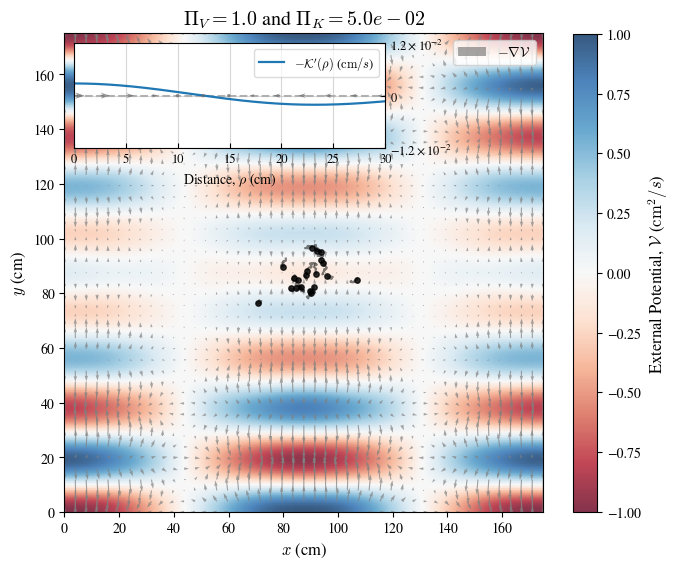

In [ ]:
# Run simulation
fig,ax = plt.subplots(1,1, figsize=(7,7))

sim.simulate(T=1, dt=0.1, save_interval=1)
sim.plot_final_state(ax, show_trajectories=True, cbar=True)

Simulating: (A,B)=(0.1,0.01)
Running simulation for 1 steps...
Step 0/1
Simulation complete!
Simulating: (A,B)=(0.1,0.05)
Running simulation for 1 steps...
Step 0/1
Simulation complete!
Simulating: (A,B)=(0.1,0.25)
Running simulation for 1 steps...
Step 0/1
Simulation complete!
Simulating: (A,B)=(0.5,0.01)
Running simulation for 1 steps...
Step 0/1
Simulation complete!
Simulating: (A,B)=(0.5,0.05)
Running simulation for 1 steps...
Step 0/1
Simulation complete!
Simulating: (A,B)=(0.5,0.25)
Running simulation for 1 steps...
Step 0/1
Simulation complete!
Simulating: (A,B)=(1.0,0.01)
Running simulation for 1 steps...
Step 0/1
Simulation complete!
Simulating: (A,B)=(1.0,0.05)
Running simulation for 1 steps...
Step 0/1
Simulation complete!
Simulating: (A,B)=(1.0,0.25)
Running simulation for 1 steps...
Step 0/1
Simulation complete!











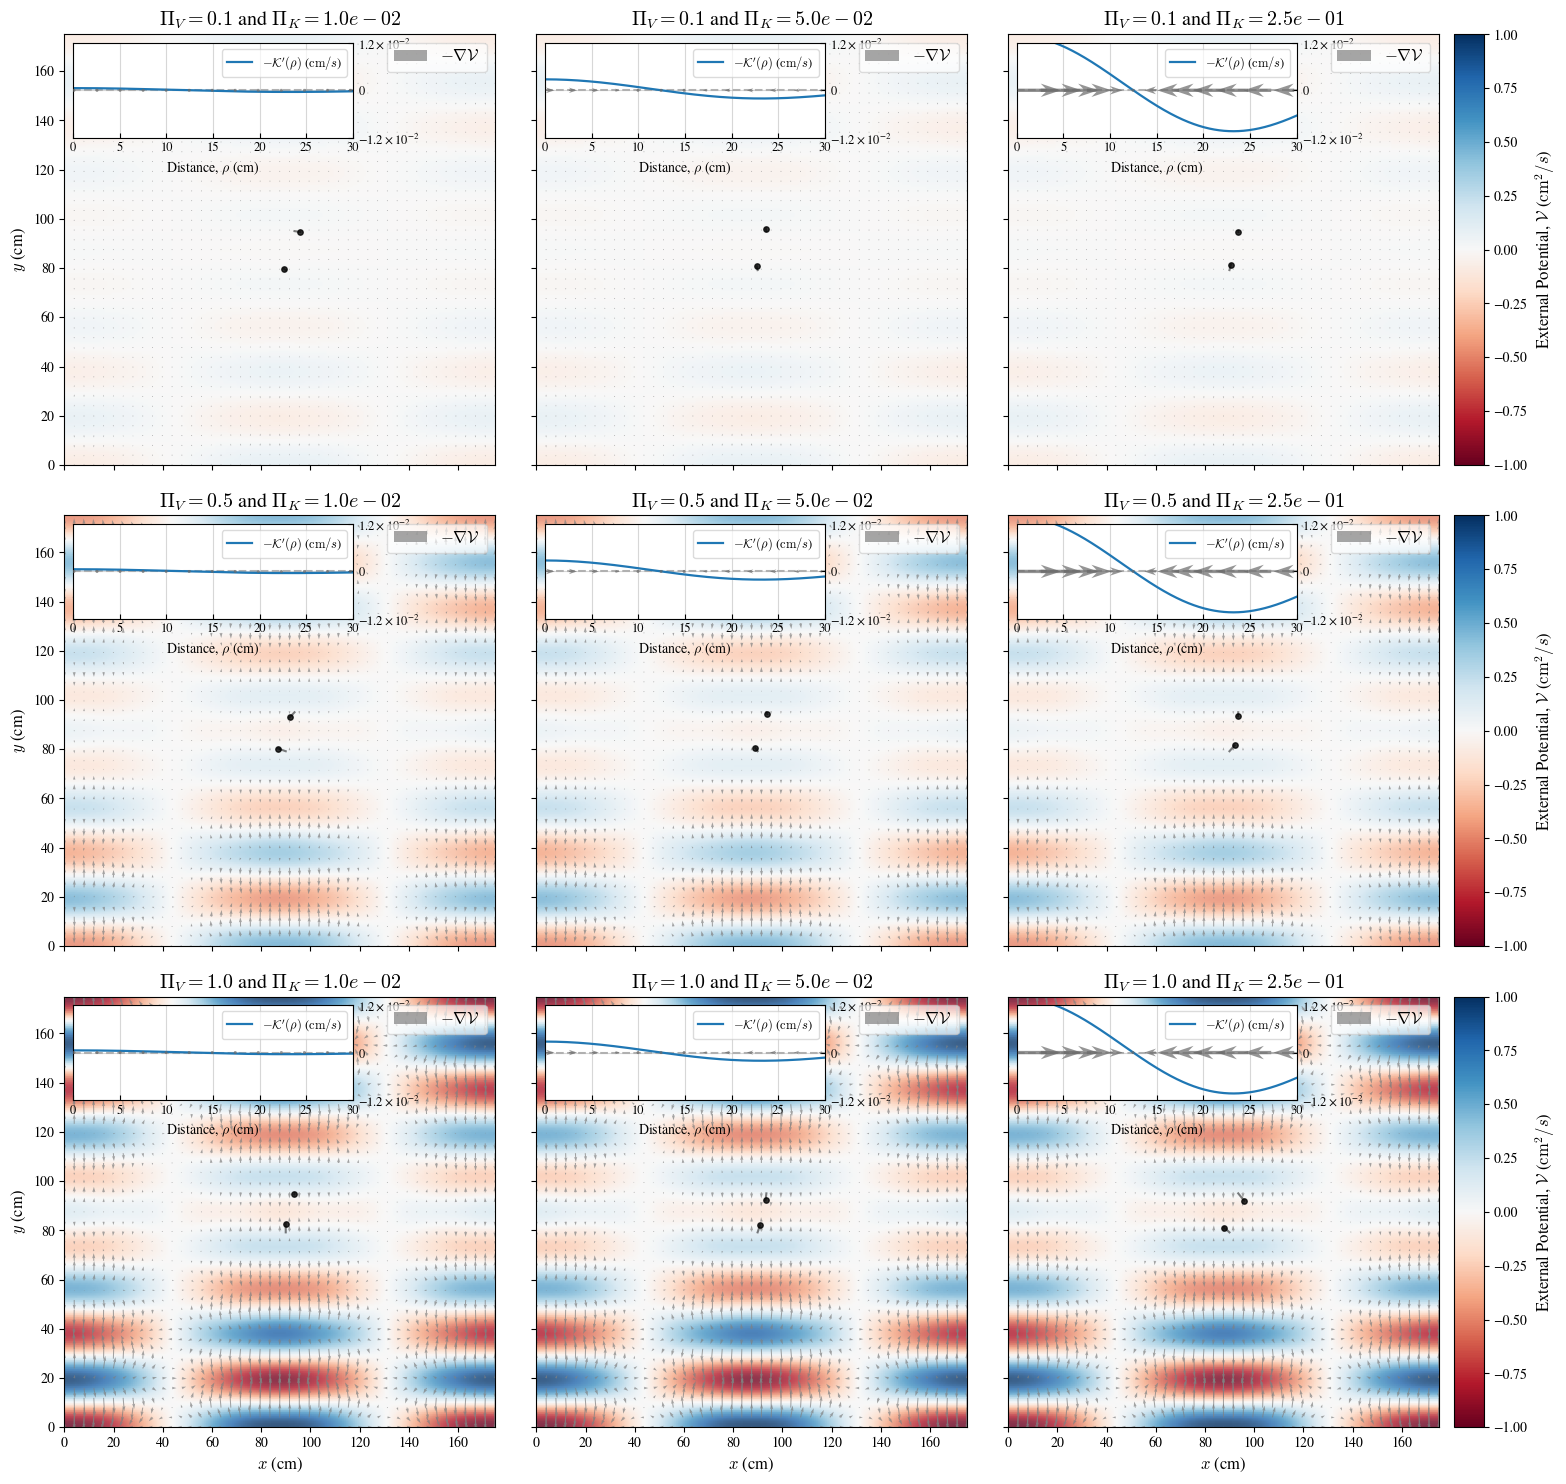

In [ ]:
import matplotlib as mpl

# Run simulations for various parameters values
As = [0.1,0.1,0.1, 0.5,0.5,0.5, 1.0,1.0,1.0] # Vc/D values
# Bs = [2.e-3,1.e-2,5.e-2, 2.e-3,1.e-2,5.e-2, 2.e-3,1.e-2,5.e-2] # Uc*Kc*tc values
Bs = [1.e-2,5.e-2,2.5e-1, 1.e-2,5.e-2,2.5e-1, 1.e-2,5.e-2,2.5e-1] # Uc*Kc*tc values

# Temporarily disable plt.show inside the class so it doesn't interrupt the loop
fig, axes = plt.subplots(3,3, figsize=(15,15), sharex=True, sharey=True)
_old_show = plt.show
plt.show = lambda *a, **k: None

for i, ax in enumerate(axes.flatten()):
  A = As[i]
  B = Bs[i]
  print(f'Simulating: (A,B)=({A},{B})')

  #sim = McKeanVlasovSimulator(N=25, L=175, A=A, B=B)
  sim = McKeanVlasovSimulator(N=2, L=175, A=A, B=B)
  sim.simulate(T=1., dt=1., save_interval=1)
  #sim.simulate(T=48, dt=0.5, save_interval=1)
  #sim.simulate(T=100, dt=0.5, save_interval=1)
  sim.plot_final_state(ax, show_trajectories=True, cbar=False)
  ax.legend(fontsize=12, framealpha=0.65)
  if i in [6,7,8]:
    ax.set_xlabel('$x$ (cm)')
  if i%3 == 0:
    ax.set_ylabel('$y$ (cm)')

plt.show = _old_show

for row in range(3):
  right_ax = axes[row, -1]
  bbox = right_ax.get_position() # [x0, y0, W, H]
  cax = fig.add_axes([bbox.x1 + 0.01, bbox.y0, 0.02, bbox.height])

  sm = mpl.cm.ScalarMappable(cmap='RdBu', norm=mpl.colors.Normalize(vmin=-1.0, vmax=1.0))
  sm.set_array([])  # required for colorbar
  cbar = fig.colorbar(sm, cax=cax)
  cbar.set_label(r'External Potential, $\mathcal{V}$ ($\mathrm{cm}^2/s$)')
  print('\n\n')

plt.show()

# Sensitivity analysis

In [ ]:
# PICK ENSEMBLE DATASET
U_ws = U_interp.clone()
N_data = cats.shape[0]
print(f'Number of cat. counts = {N_data}')

# Grid
try:
  t = torch.from_numpy(t)
  t_new = torch.from_numpy(t_new)
except:
  pass

X,Y,T = torch.meshgrid(x,y,t_new, indexing='ij')

Number of cat. counts = 964


In [ ]:
# PICK OTHER WSINDY PARAMS
coords = [x, y, t_new]
vars = []
names = ['u']

# Query-point frequency
s = [1, 1, 1]

# Derivatives for test fcns
alpha = [[0,0,1], # d/dt (lhs)
         [2,0,0], # d^2/dx^2
         [0,2,0]] # d^2/dy^2

# Powers for homogeneous fcns
beta = [[0],[1]]

# Hyper-params
params = {'V':vars, 'names':names, 's':s, 'rescale':False, 'verbosity':False}

In [ ]:
# SENSITIVITY ANALYSIS
import os

PERFORM_SA = False
WRITE_CSV = False
csv_path = "sensitivity_analysis.csv"

if PERFORM_SA:
  results = []

  # Loop over test fcn support radii
  [max_mxy, max_mt] = [20, 20]

  #for mxy in [mxy for mxy in range(2, max_mxy+1)]:
  for mxy in tqdm(range(2, max_mxy + 1), desc="mxy"):
    for mt in [my for my in range(2, max_mt+1)]:

      # Set test fcn support
      params['m'] = [mxy, mxy, mt]
      model = WSINDy(U_ws, alpha, beta, coords, **params)

      # Set lhs
      lhs_name = 'u' + model.derivative_names[0]
      model.build_lhs(lhs_name)

      # Create library with single Laplacian term
      info = model.create_default_library()
      [G,powers,derivs,rhs_names] = composite_term([0,1], [1,1], 'Δu', model, info)
      model.set_library(G, powers, derivs, rhs_names)

      # Find sparse weights
      w = model.MSTLS()
      Deff = w[0].item()

      # Compute R^2 and AIC
      r = (model.lhs - model.library @ model.coeffs).clone()
      bbar = model.lhs.mean().clone()
      R2 = 1 - (r@r)/((model.lhs-bbar)@(model.lhs-bbar))
      R2 = R2.item()

      AIC = 2*1 + N_data*np.log((r@r).item())
      AIC = AIC.item()

      # Parameter variance
      G_dagger = la.pinv(model.library.clone())
      S = G_dagger @ ((r.clone()**2).unsqueeze(1) * G_dagger.T)
      sigma = torch.sqrt(torch.diag(S))[0].item()

      # Append results
      results.append({"mxy":mxy, "mt":mt, "Deff":Deff, "R2": R2, "AIC": AIC, "sigma": sigma})

  # Write out results
  df = pd.DataFrame(results, columns=["mxy", "mt", "Deff", "R2", "AIC", "sigma"])
  print('\n\nFINSIHED:\n', df.head())
  if WRITE_CSV:
    df.to_csv(csv_path, index=False)
    print(f"\nSensitivity results saved to: {os.path.abspath(csv_path)}")

100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

100%|██████████| 2/2 [00:00<00:00, 10.87it/s]

100%|██████████| 2/2 [00:00<00:00, 11.95it/s]

100%|██████████| 2/2 [00:00<00:00, 10.15it/s]

100%|██████████| 2/2 [00:00<00:00,  8.15it/s]

100%|██████████| 2/2 [00:00<00:00, 10.37it/s]

100%|██████████| 2/2 [00:00<00:00, 10.17it/s]

100%|██████████| 2/2 [00:00<00:00,  8.79it/s]

100%|██████████| 2/2 [00:00<00:00,  7.06it/s]

100%|██████████| 2/2 [00:00<00:00,  8.10it/s]

100%|██████████| 2/2 [00:00<00:00,  9.62it/s]

100%|██████████| 2/2 [00:00<00:00, 10.65it/s]

100%|██████████| 2/2 [00:00<00:00, 10.41it/s]

100%|██████████| 2/2 [00:00<00:00, 10.82it/s]

100%|██████████| 2/2 [00:00<00:00,  9.51it/s]

100%|██████████| 2/2 [00:00<00:00,  9.10it/s]

100%|██████████| 2/2 [00:00<00:00,  9.74it/s]

100%|██████████| 2/2 [00:00<00:00, 11.60it/s]

100%|██████████| 2/2 [00:00<00:00, 12.13it/s]

100%|██████████| 2/2 [00:00<00:00,  9.92it/s]

100%|████████



FINSIHED:
    mxy  mt          Deff        R2           AIC         sigma
0    2   2  2.320389e-11  0.237718 -44676.694049  5.990281e-13
1    2   3  4.483096e-04  0.261372 -12468.537810  9.102048e-06
2    2   4  2.324685e-03  0.296106  -8997.618299  4.565313e-05
3    2   5  2.409309e-03  0.298999  -8386.445521  4.694802e-05
4    2   6  2.257537e-03  0.295231  -8060.226107  4.227687e-05


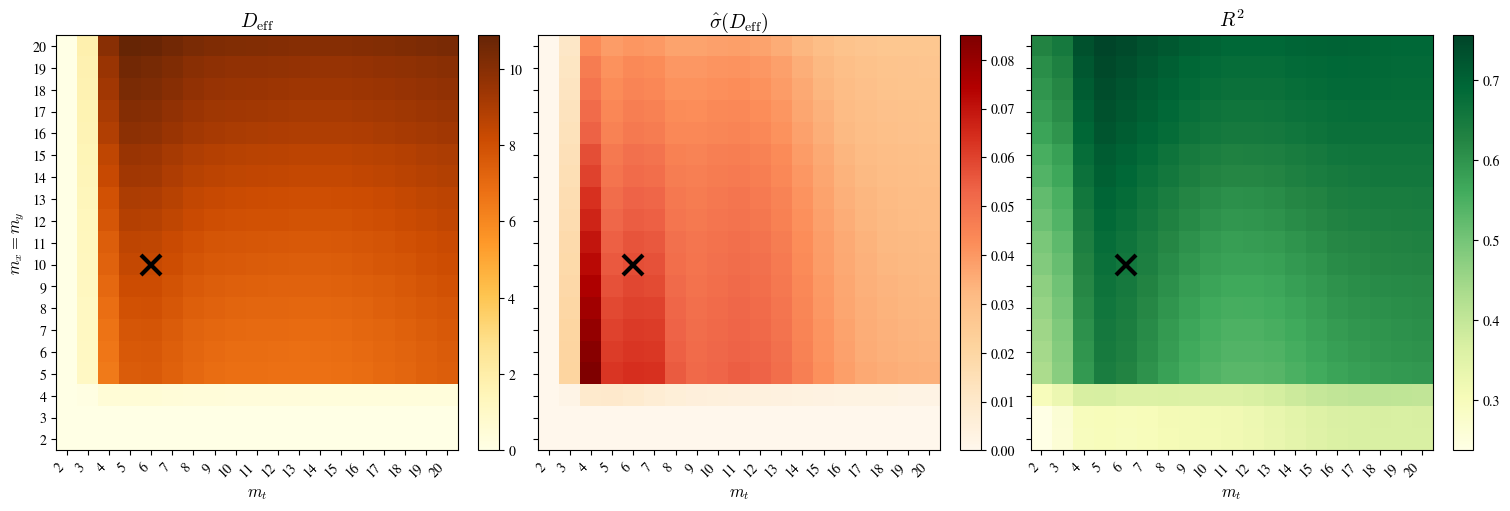

In [ ]:
# PLOT THE PARAMETER SWEEPS
value_cols = ["Deff", "sigma", "R2"]
titles = [r"$D_{\text{eff}}$", r"$\hat\sigma(D_{\text{eff}})$", r"$R^2$"]
cmaps = ["YlOrBr", "OrRd", "YlGn"]

mxy_vals = np.sort(df["mxy"].unique())
mt_vals = np.sort(df["mt"].unique())

matrices = []
for col in value_cols:
  pivot = df.pivot(index="mxy", columns="mt", values=col)
  pivot = pivot.reindex(index=mxy_vals, columns=mt_vals)
  mat = np.ma.masked_invalid(pivot.values.astype(float))
  matrices.append((mat, pivot.index, pivot.columns))

vmin = vmax = None

# 'X' marks the spot!
[mark_mxy, mark_mt] = [10, 6]
xi = int(np.where(mt_vals == mark_mt)[0][0])
yi = int(np.where(mxy_vals == mark_mxy)[0][0])

# Plot the heatmaps
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True, constrained_layout=True)
for ax, (mat, i_vals, c_vals), title, cmap in zip(axes, matrices, titles, cmaps):
  im = ax.imshow(mat, aspect="auto", origin="lower", cmap=cmap)
  ax.plot(xi, yi, 'x', ms=14, markeredgewidth=3, markeredgecolor='k', ls='None')

  ax.set_xticks(np.arange(len(c_vals)))
  ax.set_xticklabels([str(c) for c in c_vals], rotation=45, ha="right")
  if ax is axes[0]:
    ax.set_yticks(np.arange(len(i_vals)))
    ax.set_yticklabels([str(i) for i in i_vals])
    ax.set_ylabel("$m_x = m_y$")
  else:
    ax.set_yticks(np.arange(len(i_vals)))
  ax.set_xlabel("$m_t$")
  ax.set_title(title)

  if ax is axes[0]:
    ax.set_ylabel("$m_x = m_y$")
  else:
    ax.set_ylabel("")
  cbar = fig.colorbar(im, ax=ax)

plt.show()